# DeepSDF в картинках
## Проект к курсу «Дополнительные главы машинного обучения», Колодзей 599б

В этой тетрадке я перескажу основные идеи из статьи [DeepSDF: Learning Continuous Signed Distance Functions for Shape Representation](https://arxiv.org/abs/1901.05103). Зачем пересказ, когда есть сама статья? Затем, что тут есть код и сгенерированные им картинки!

В статье рассматриваются 3D-фигуры. В пересказе, для простоты, будут картинки про 2D-фигуры.

<img src="3Dvs2D.png">

Кроме того, фигуры у меня будут простые, а нейросети для их кодирования совсем неглубокие. Цель пересказа — не воспроизведение state-of-the-art результата, а наглядное представление идей статьи так, чтобы с ними можно было вот прям в тетрадке начать играть.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

## Знаковая функция расстояния (SDF)

Итак, пусть у нас есть некоторая *фигура* (shape) в 3D или 2D. Как её вообще представить в компьютерно-читаемом виде? Человечество придумало много способов, например:

+ Облака точек (point cloud): хранить множество точек с поверхности фигуры (такие данные часто получаются с сенсоров)
+ Мэши (mesh): хранить приближение поверхности фигуры многоугольниками (чаще — треугольниками)
+ Воксели (voxels): для каждого кубика пространства хранить, занят он фигурой или нет

В статье рассматривается ещё один способ: кодирование с помощью *знаковой функцией расстояния* (signed distance function, SDF). Для точки $x$ снаружи фигуры её знаковая функция расстояния $sdf(x)$ — это расстояние $\rho(x, S)$ от этой точки до поверхности $S$ фигуры. Для точки внутри — это $-\rho(x, S)$, т. е. расстояние до поверхности, взятое со знаком минус.

$$sdf(x) = \begin{cases}
  \rho(x, S),  & \mbox{если } x \mbox{ снаружи} \\
  -\rho(x, S), & \mbox{если } x \mbox{ внутри}
\end{cases}$$

Давайте закодим фигуры-примеры: круги и многоугольники.

In [2]:
class Geometry:
    EPS = 1e-12
    """
    Класс-namespace с геометрическими функциями
    """
    def distance_from_segment_to_point(a, b, p):
        ans = min(np.linalg.norm(a - p), np.linalg.norm(b - p))
        if (np.linalg.norm(a - b) > Geometry.EPS 
            and np.dot(p - a, b - a) > Geometry.EPS 
            and np.dot(p - b, a - b) > Geometry.EPS):
            ans = abs(np.cross(p - a, b - a) / np.linalg.norm(b - a))
        return ans


class Shape:
    def sdf(self, p):
        pass
    
    
class Circle(Shape):
    
    def __init__(self, c, r):
        self.c = c
        self.r = r
    
    def sdf(self, p):
        return np.linalg.norm(p - self.c) - self.r
    
    
class Polygon(Shape):
    
    def __init__(self, v):
        self.v = v
    
    def sdf(self, p):
        return -self.distance(p) if self.point_is_inside(p) else self.distance(p)
    
    def point_is_inside(self, p):
        angle_sum = 0
        L = len(self.v)
        for i in range(L):
            a = self.v[i]
            b = self.v[(i + 1) % L]
            angle_sum += np.arctan2(np.cross(a - p, b - p), np.dot(a - p, b - p))
        return abs(angle_sum) > 1
            
    def distance(self, p):
        ans = Geometry.distance_from_segment_to_point(self.v[-1], self.v[0], p)
        for i in range(len(self.v) - 1):
            ans = min(ans, Geometry.distance_from_segment_to_point(self.v[i], self.v[i + 1], p))
        return ans

Напишем функцию, которая изображает знаковую функцию расстояния.

In [3]:
def plot_sdf(sdf_func):
    # See https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
    COORDINATES_LINSPACE = np.linspace(-3, 3, 100)
    y, x = np.meshgrid(COORDINATES_LINSPACE, COORDINATES_LINSPACE)
    z = np.float_([[sdf_func(np.float_([x_, y_])) 
                    for y_ in  COORDINATES_LINSPACE] 
                    for x_ in COORDINATES_LINSPACE])
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    fig, ax = plt.subplots(figsize=(10, 10))
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    
    # я не умею показывать colorbar так, чтобы пропорции heatmap не исказились ._.
    # fig.colorbar(c, ax=ax)

Посмотрим на график для круга

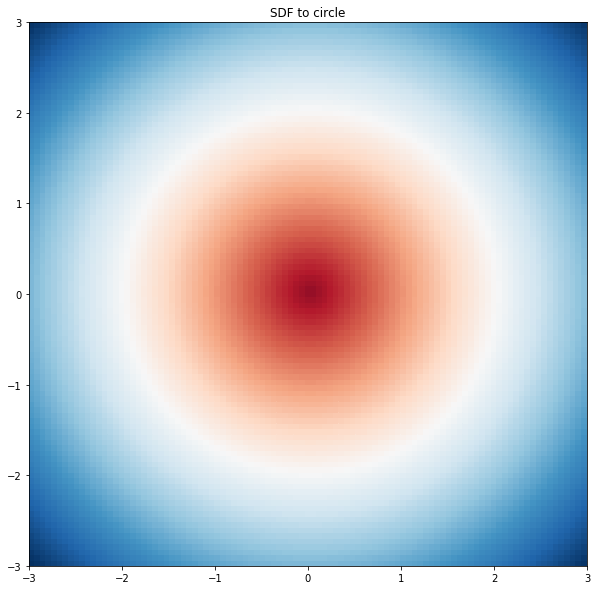

In [4]:
# круг с центром в начале координат и радиусом 2
circle = Circle(np.float_([0, 0]), 2)
plot_sdf(circle.sdf)
plt.title("SDF to circle")
plt.show()

И на график для прямоугольника

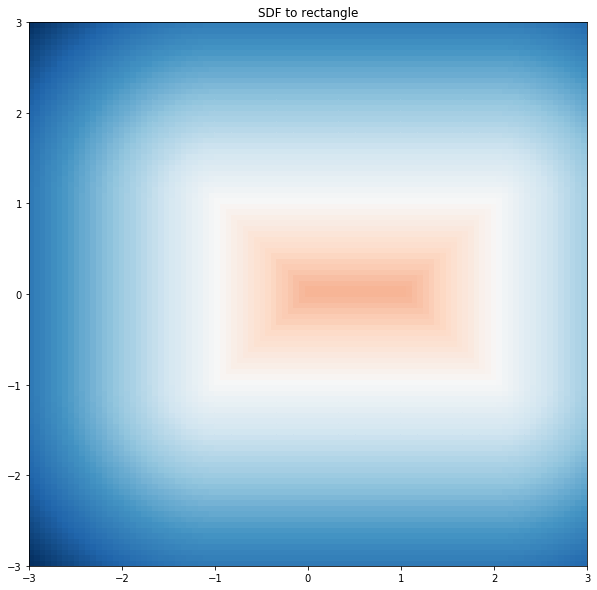

In [5]:
# многоугольник с вершинами в указанных точках
rectangle = Polygon(np.float_([[-1, -1], [-1, 1], [2, 1], [2, -1]]))
plot_sdf(rectangle.sdf)
plt.title("SDF to rectangle")
plt.show()

## Кодирование SDF с помощью нейронной сети

Давайте построим приближение знаковой функции расстояния одной конкретной фигуры (круга) с помощью нейросети. Например, простейшей нейросети с одним скрытым слоем.

<img src="architecture.png">

На входном слое этой неросети 2 нейрона: сеть принимает на вход координаты точки. На выходном слое один нейрон — знаковая функция расстояния до принятной на вход точки.

In [109]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)


Сгенерируем обучающую выборку: значения знаковой функции расстояния для фигуры в наборе точек.

$$ TRAIN := \{((x, y), s) : SDF(x, y) = s\} $$

Точки выберем, равномерно просэмплировав знаковую функцию расстояния около фигуры.

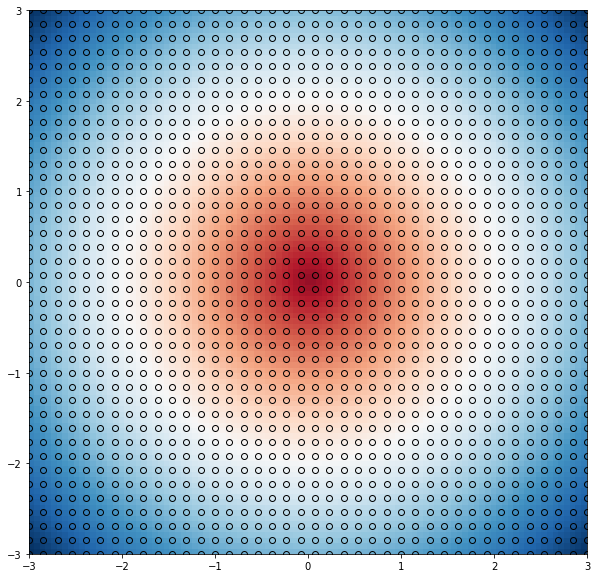

In [112]:
points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(-3, 3, 40) 
                    for x_ in np.linspace(-3, 3, 40)])
sdf_train = np.float_(list(map(circle.sdf, points_train)))

plot_sdf(circle.sdf)
plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#000000")

Для обучения нейросети будет удобно перевести данные в pytorch-формат. Заодно пошаффлим.

In [113]:
train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

В качестве функции потерь возьмём `l1_loss`.

$$ Loss(net(x, y), sdf(x, y)) = |net(x, y) - sdf(x, y)| $$

В оригинальной статье функция потерь чуть более хитрая и выглядит так:

$$ Loss(net(x, y), sdf(x, y)) = |clamp(net(x, y), \delta) - clamp(sdf(x, y), \delta)| $$

где $clamp(x, \delta) = min(\delta, max(-\delta, x))$

Такая хитрая функция потерь взята, чтобы сконцентировать выразительную способность нейросети около поверхности фигуры.


Epoch: 0 Loss: 0.9708690047264099


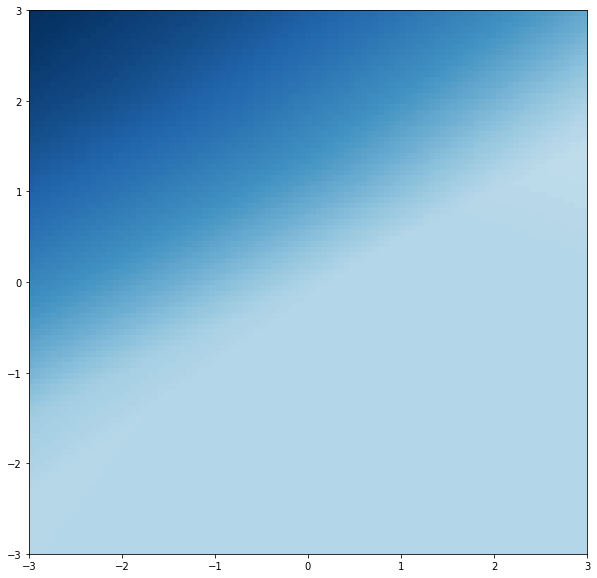

Epoch: 1 Loss: 0.7025208473205566
Epoch: 2 Loss: 0.6976280212402344
Epoch: 3 Loss: 0.6939030289649963
Epoch: 4 Loss: 0.6905637383460999
Epoch: 5 Loss: 0.6874203681945801
Epoch: 6 Loss: 0.6842172145843506
Epoch: 7 Loss: 0.6809297204017639
Epoch: 8 Loss: 0.6775005459785461
Epoch: 9 Loss: 0.6738433837890625
Epoch: 10 Loss: 0.669779360294342


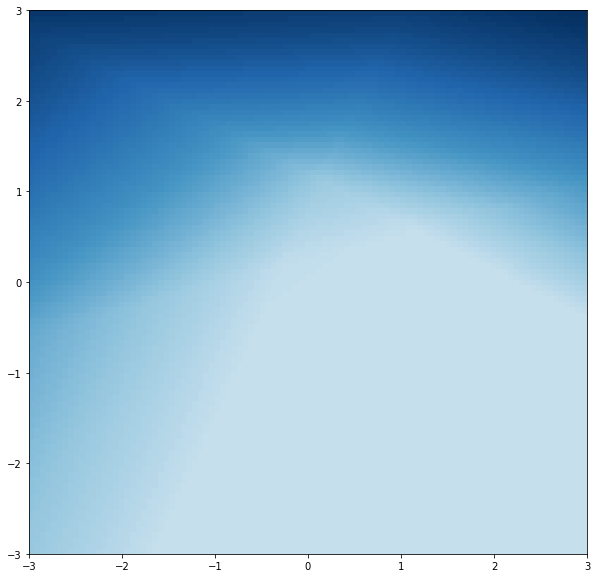

Epoch: 11 Loss: 0.6648172736167908
Epoch: 12 Loss: 0.6587619781494141
Epoch: 13 Loss: 0.6510570049285889
Epoch: 14 Loss: 0.6419646739959717
Epoch: 15 Loss: 0.6319790482521057
Epoch: 16 Loss: 0.6223517060279846
Epoch: 17 Loss: 0.6135653257369995
Epoch: 18 Loss: 0.6058624386787415
Epoch: 19 Loss: 0.5991961359977722
Epoch: 20 Loss: 0.5931954979896545


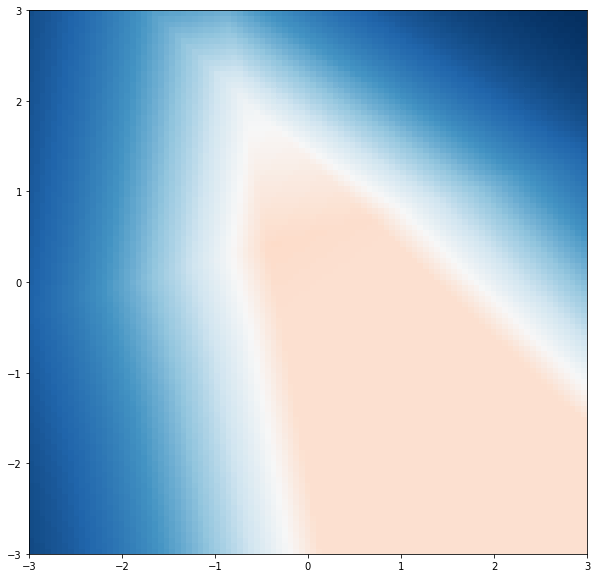

Epoch: 21 Loss: 0.587258517742157
Epoch: 22 Loss: 0.5810152888298035
Epoch: 23 Loss: 0.5737144947052002
Epoch: 24 Loss: 0.5645385384559631
Epoch: 25 Loss: 0.5516479015350342
Epoch: 26 Loss: 0.5313504338264465
Epoch: 27 Loss: 0.502446711063385
Epoch: 28 Loss: 0.4682941138744354
Epoch: 29 Loss: 0.43715494871139526
Epoch: 30 Loss: 0.43578165769577026


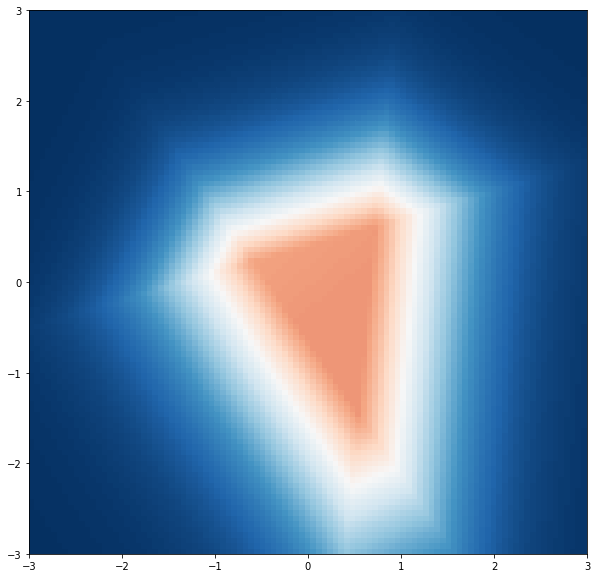

Epoch: 31 Loss: 0.5398083329200745
Epoch: 32 Loss: 0.37525150179862976
Epoch: 33 Loss: 0.3679431080818176
Epoch: 34 Loss: 0.39193761348724365
Epoch: 35 Loss: 0.5164337158203125
Epoch: 36 Loss: 0.6794407367706299
Epoch: 37 Loss: 0.5668419003486633
Epoch: 38 Loss: 0.34940996766090393
Epoch: 39 Loss: 0.33748313784599304
Epoch: 40 Loss: 0.3974827826023102


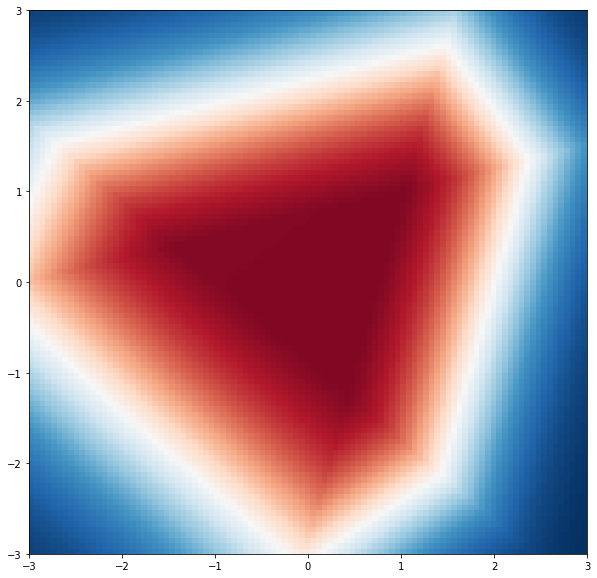

Epoch: 41 Loss: 0.5046740174293518
Epoch: 42 Loss: 0.6060208082199097
Epoch: 43 Loss: 0.42945289611816406
Epoch: 44 Loss: 0.41426926851272583
Epoch: 45 Loss: 0.525510311126709
Epoch: 46 Loss: 0.36210545897483826
Epoch: 47 Loss: 0.3031390905380249
Epoch: 48 Loss: 0.2964403033256531
Epoch: 49 Loss: 0.2970711588859558
Epoch: 50 Loss: 0.33482369780540466


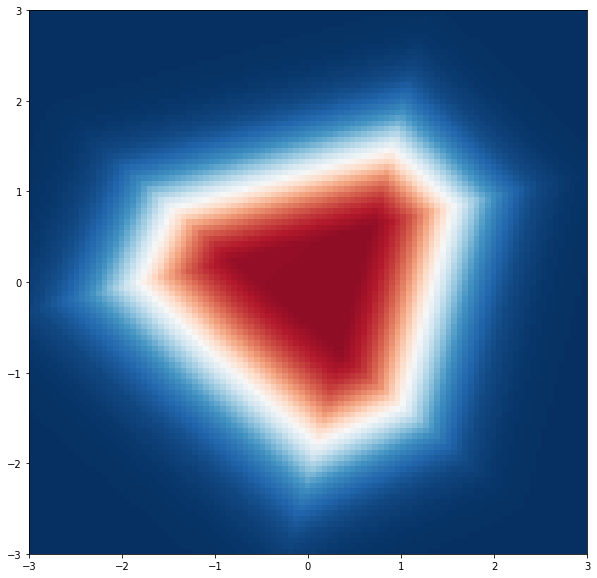

Epoch: 51 Loss: 0.43654143810272217
Epoch: 52 Loss: 0.3456624150276184
Epoch: 53 Loss: 0.44991081953048706
Epoch: 54 Loss: 0.34946563839912415
Epoch: 55 Loss: 0.40641310811042786
Epoch: 56 Loss: 0.3535485863685608
Epoch: 57 Loss: 0.4105364978313446
Epoch: 58 Loss: 0.351529985666275
Epoch: 59 Loss: 0.4037654995918274
Epoch: 60 Loss: 0.3516291677951813


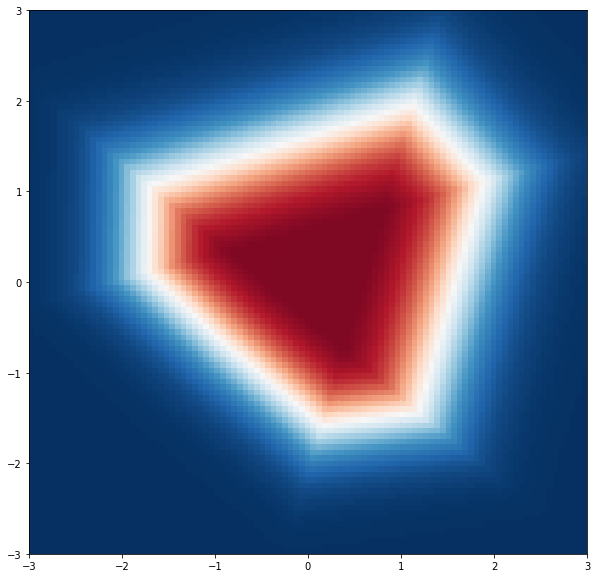

Epoch: 61 Loss: 0.37935683131217957
Epoch: 62 Loss: 0.31935569643974304
Epoch: 63 Loss: 0.38051837682724
Epoch: 64 Loss: 0.33336272835731506
Epoch: 65 Loss: 0.4239632487297058
Epoch: 66 Loss: 0.3262998163700104
Epoch: 67 Loss: 0.3914889991283417
Epoch: 68 Loss: 0.3367803692817688
Epoch: 69 Loss: 0.3957059383392334
Epoch: 70 Loss: 0.3536688983440399


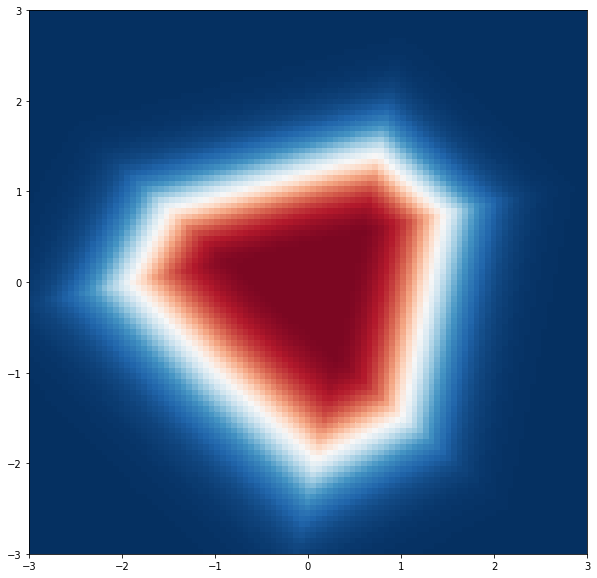

Epoch: 71 Loss: 0.43380576372146606
Epoch: 72 Loss: 0.32550284266471863
Epoch: 73 Loss: 0.33277976512908936
Epoch: 74 Loss: 0.2874835133552551
Epoch: 75 Loss: 0.3001784086227417
Epoch: 76 Loss: 0.36449721455574036
Epoch: 77 Loss: 0.4976383447647095
Epoch: 78 Loss: 0.3026164770126343
Epoch: 79 Loss: 0.3025425970554352
Epoch: 80 Loss: 0.3711497485637665


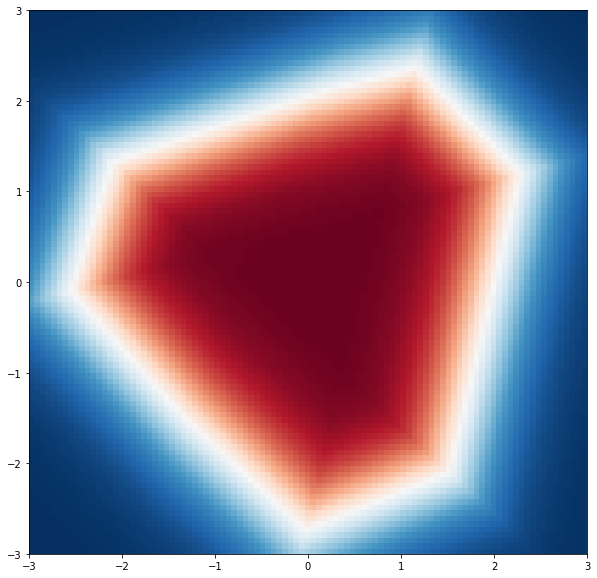

Epoch: 81 Loss: 0.3344222903251648
Epoch: 82 Loss: 0.4526832699775696
Epoch: 83 Loss: 0.2666991055011749
Epoch: 84 Loss: 0.2696112096309662
Epoch: 85 Loss: 0.291004478931427
Epoch: 86 Loss: 0.35404956340789795
Epoch: 87 Loss: 0.37218648195266724
Epoch: 88 Loss: 0.5025044083595276
Epoch: 89 Loss: 0.3175111711025238
Epoch: 90 Loss: 0.29348450899124146


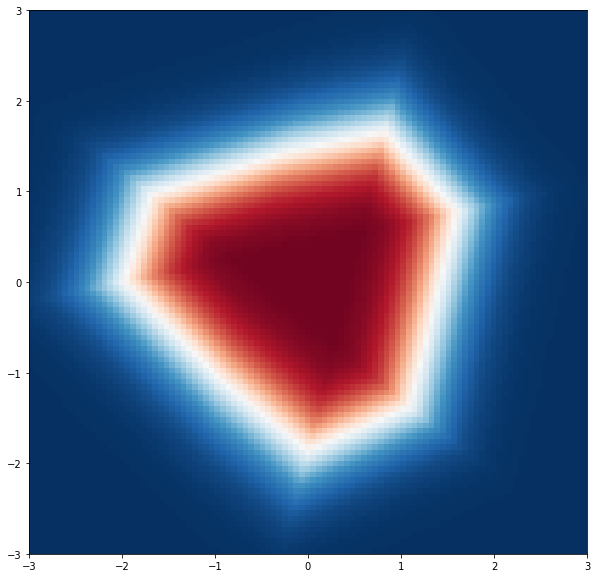

Epoch: 91 Loss: 0.3795698583126068
Epoch: 92 Loss: 0.3122017979621887
Epoch: 93 Loss: 0.4238143563270569
Epoch: 94 Loss: 0.2782354950904846
Epoch: 95 Loss: 0.3354642987251282
Epoch: 96 Loss: 0.3557290732860565
Epoch: 97 Loss: 0.4972814917564392
Epoch: 98 Loss: 0.3058536648750305
Epoch: 99 Loss: 0.37009283900260925
Epoch: 100 Loss: 0.4967697858810425


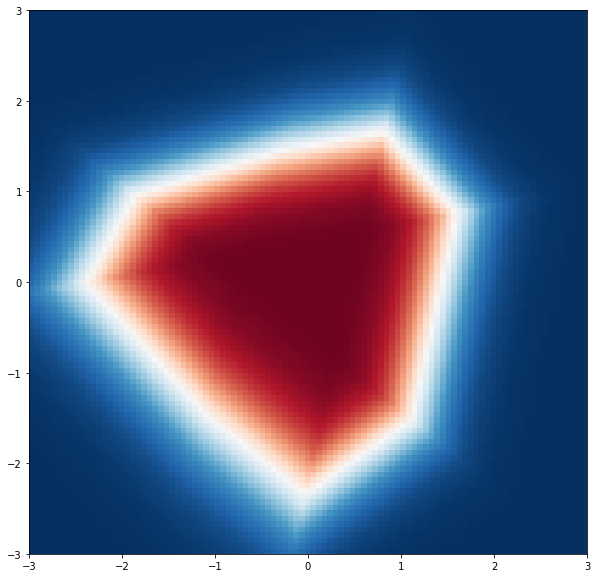

Epoch: 101 Loss: 0.33750370144844055
Epoch: 102 Loss: 0.2675909101963043
Epoch: 103 Loss: 0.27950185537338257
Epoch: 104 Loss: 0.32007887959480286
Epoch: 105 Loss: 0.4366866648197174
Epoch: 106 Loss: 0.26056206226348877
Epoch: 107 Loss: 0.26032623648643494
Epoch: 108 Loss: 0.274580717086792
Epoch: 109 Loss: 0.3019028902053833
Epoch: 110 Loss: 0.3046199679374695


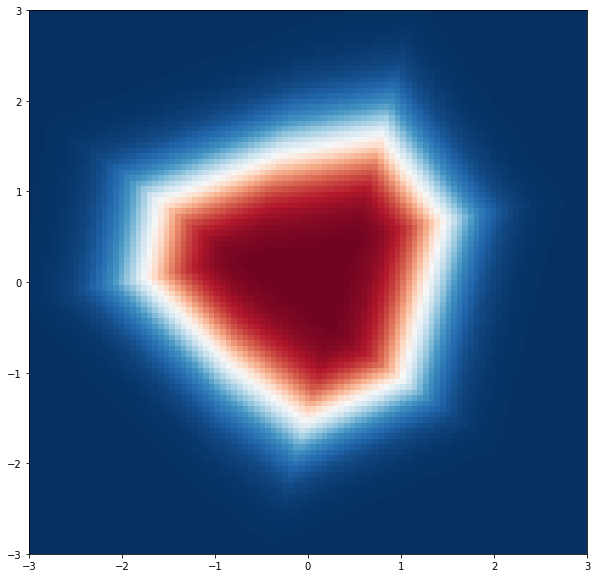

Epoch: 111 Loss: 0.459003746509552
Epoch: 112 Loss: 0.2848474383354187
Epoch: 113 Loss: 0.27442455291748047
Epoch: 114 Loss: 0.3021344244480133
Epoch: 115 Loss: 0.280055433511734
Epoch: 116 Loss: 0.4216545820236206
Epoch: 117 Loss: 0.2764584720134735
Epoch: 118 Loss: 0.35937026143074036
Epoch: 119 Loss: 0.3459499776363373
Epoch: 120 Loss: 0.449718177318573


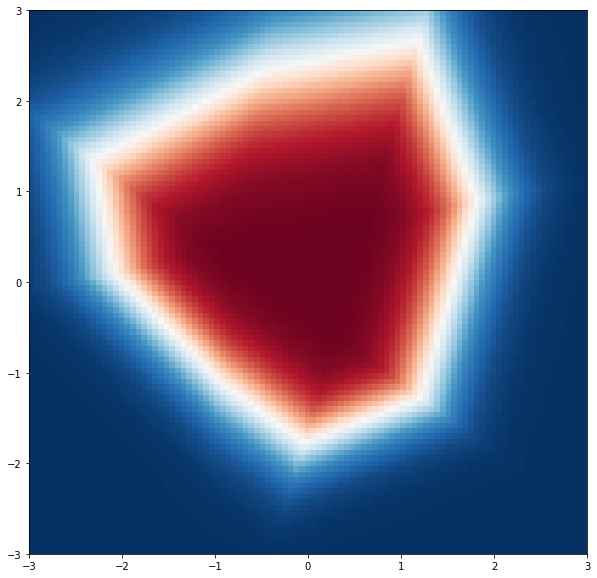

Epoch: 121 Loss: 0.383584201335907
Epoch: 122 Loss: 0.3226049542427063
Epoch: 123 Loss: 0.2832702398300171
Epoch: 124 Loss: 0.3898497521877289
Epoch: 125 Loss: 0.29607877135276794
Epoch: 126 Loss: 0.3358432352542877
Epoch: 127 Loss: 0.33415549993515015
Epoch: 128 Loss: 0.4482356011867523
Epoch: 129 Loss: 0.3451497554779053
Epoch: 130 Loss: 0.3038303256034851


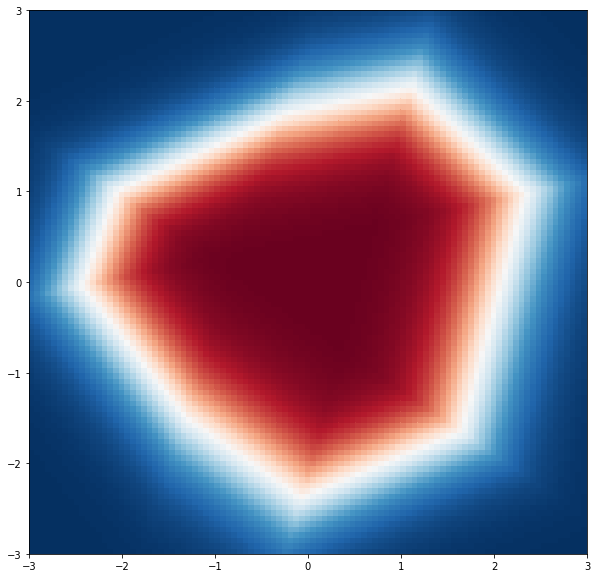

Epoch: 131 Loss: 0.2748013436794281
Epoch: 132 Loss: 0.36615240573883057
Epoch: 133 Loss: 0.29770809412002563
Epoch: 134 Loss: 0.42134514451026917
Epoch: 135 Loss: 0.2585238218307495
Epoch: 136 Loss: 0.2906126081943512
Epoch: 137 Loss: 0.3042914569377899
Epoch: 138 Loss: 0.44913560152053833
Epoch: 139 Loss: 0.2535233497619629
Epoch: 140 Loss: 0.28893256187438965


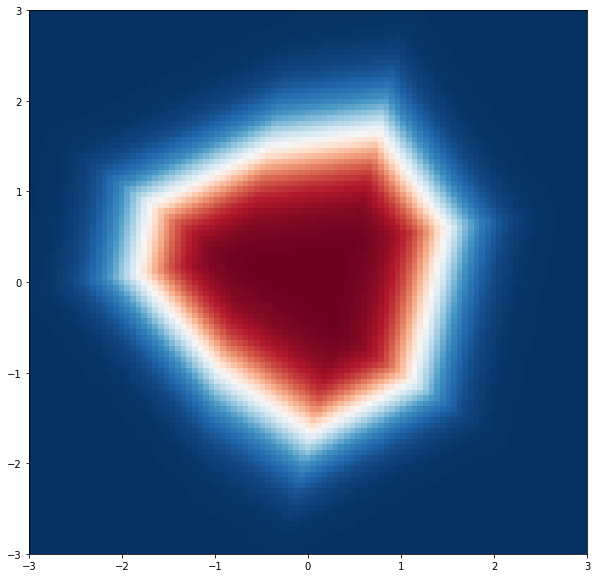

Epoch: 141 Loss: 0.42611366510391235
Epoch: 142 Loss: 0.2694041430950165
Epoch: 143 Loss: 0.2771543562412262
Epoch: 144 Loss: 0.26617568731307983
Epoch: 145 Loss: 0.26481500267982483
Epoch: 146 Loss: 0.29827776551246643
Epoch: 147 Loss: 0.26219722628593445
Epoch: 148 Loss: 0.3405776619911194
Epoch: 149 Loss: 0.29453912377357483
Epoch: 150 Loss: 0.40464964509010315


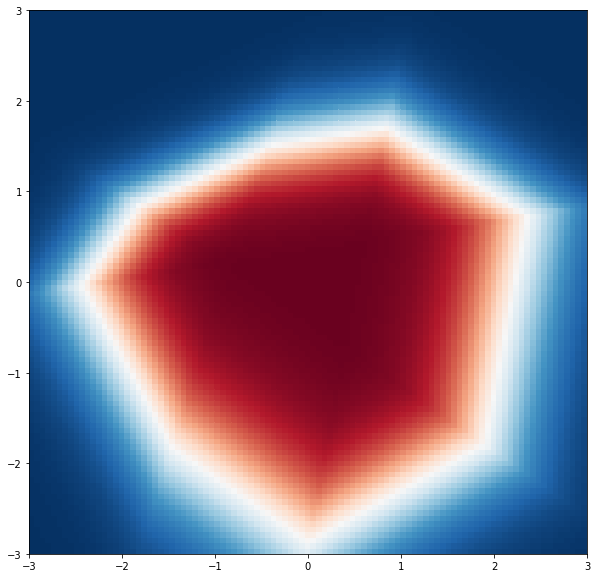

Epoch: 151 Loss: 0.3690482974052429
Epoch: 152 Loss: 0.42564553022384644
Epoch: 153 Loss: 0.34414294362068176
Epoch: 154 Loss: 0.31423598527908325
Epoch: 155 Loss: 0.2506067752838135
Epoch: 156 Loss: 0.24265073239803314
Epoch: 157 Loss: 0.24661484360694885
Epoch: 158 Loss: 0.2674029469490051
Epoch: 159 Loss: 0.3887586295604706
Epoch: 160 Loss: 0.33164364099502563


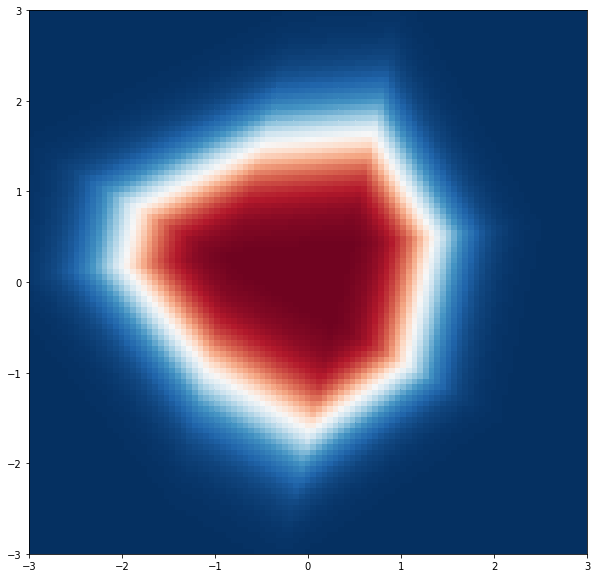

Epoch: 161 Loss: 0.4353716969490051
Epoch: 162 Loss: 0.30141976475715637
Epoch: 163 Loss: 0.27628618478775024
Epoch: 164 Loss: 0.3242367208003998
Epoch: 165 Loss: 0.5206126570701599
Epoch: 166 Loss: 0.35830965638160706
Epoch: 167 Loss: 0.3076612949371338
Epoch: 168 Loss: 0.3733675479888916
Epoch: 169 Loss: 0.34077948331832886
Epoch: 170 Loss: 0.37433987855911255


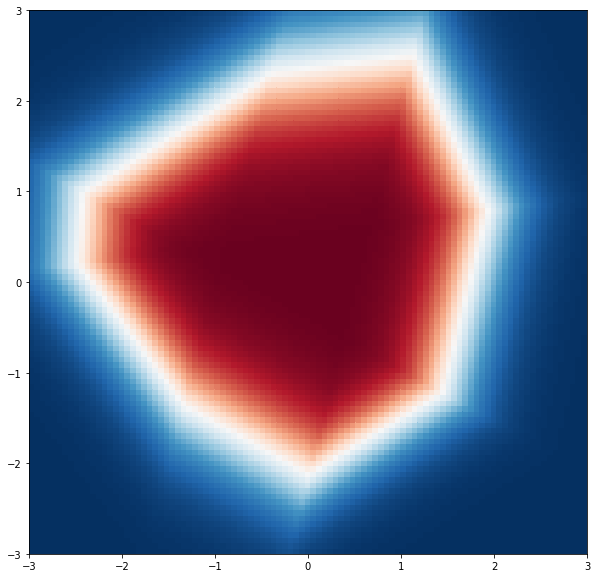

Epoch: 171 Loss: 0.30565258860588074
Epoch: 172 Loss: 0.28973057866096497
Epoch: 173 Loss: 0.24960961937904358
Epoch: 174 Loss: 0.25721561908721924
Epoch: 175 Loss: 0.2767215669155121
Epoch: 176 Loss: 0.3856460452079773
Epoch: 177 Loss: 0.33397376537323
Epoch: 178 Loss: 0.3281283974647522
Epoch: 179 Loss: 0.27492234110832214
Epoch: 180 Loss: 0.3383978009223938


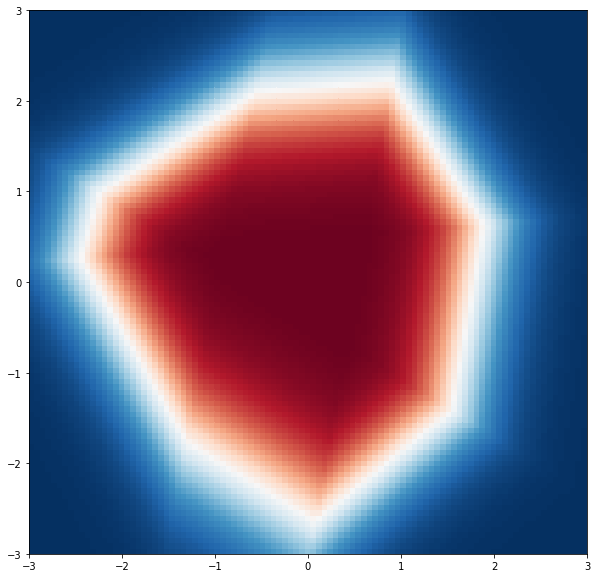

Epoch: 181 Loss: 0.281255841255188
Epoch: 182 Loss: 0.3231259286403656
Epoch: 183 Loss: 0.3440309166908264
Epoch: 184 Loss: 0.4677698612213135
Epoch: 185 Loss: 0.302573025226593
Epoch: 186 Loss: 0.2563922107219696
Epoch: 187 Loss: 0.3143158555030823
Epoch: 188 Loss: 0.3720109164714813
Epoch: 189 Loss: 0.510947048664093
Epoch: 190 Loss: 0.35267215967178345


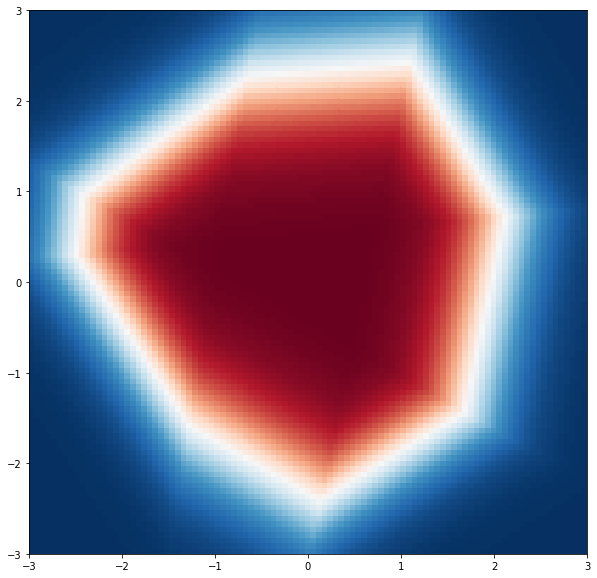

Epoch: 191 Loss: 0.29366397857666016
Epoch: 192 Loss: 0.3646048307418823
Epoch: 193 Loss: 0.3187158703804016
Epoch: 194 Loss: 0.37300121784210205
Epoch: 195 Loss: 0.303109347820282
Epoch: 196 Loss: 0.2933283746242523
Epoch: 197 Loss: 0.2518303692340851
Epoch: 198 Loss: 0.25358638167381287
Epoch: 199 Loss: 0.27728697657585144
Epoch: 200 Loss: 0.2582393288612366


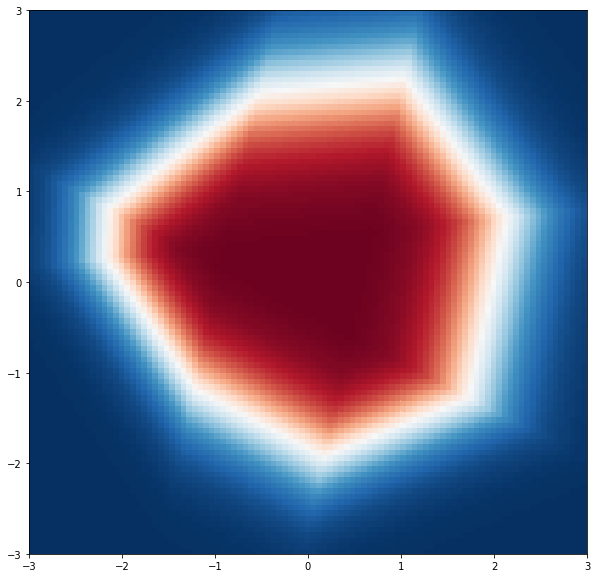

Epoch: 201 Loss: 0.2654290497303009
Epoch: 202 Loss: 0.2779919505119324
Epoch: 203 Loss: 0.2882796823978424
Epoch: 204 Loss: 0.2629900872707367
Epoch: 205 Loss: 0.3472137451171875
Epoch: 206 Loss: 0.31503650546073914
Epoch: 207 Loss: 0.3784535229206085
Epoch: 208 Loss: 0.347488135099411
Epoch: 209 Loss: 0.3857770562171936
Epoch: 210 Loss: 0.2820553481578827


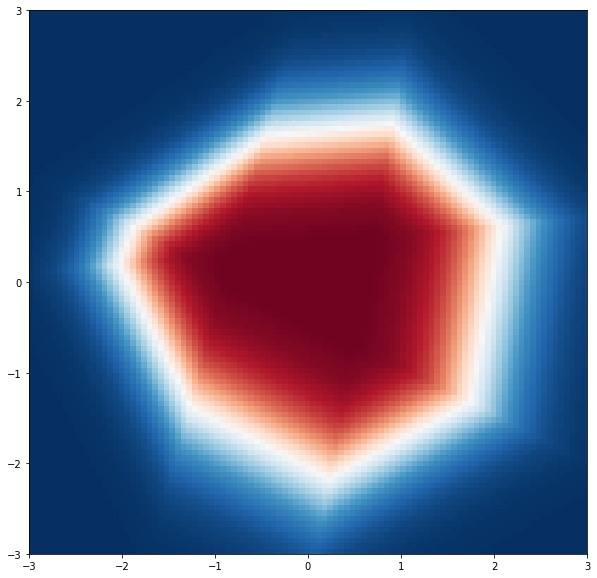

Epoch: 211 Loss: 0.2742258608341217
Epoch: 212 Loss: 0.2937471270561218
Epoch: 213 Loss: 0.48114094138145447
Epoch: 214 Loss: 0.3110363185405731
Epoch: 215 Loss: 0.30071333050727844
Epoch: 216 Loss: 0.4462236762046814
Epoch: 217 Loss: 0.2551795542240143
Epoch: 218 Loss: 0.3230431377887726
Epoch: 219 Loss: 0.4726126194000244
Epoch: 220 Loss: 0.30871573090553284


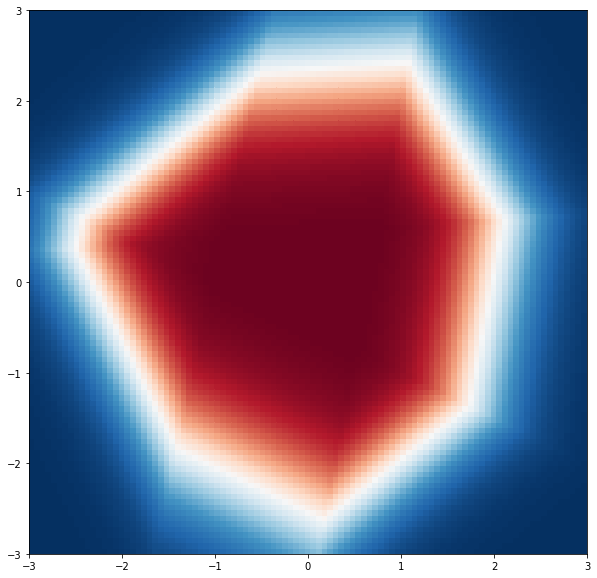

Epoch: 221 Loss: 0.30727723240852356
Epoch: 222 Loss: 0.3785746395587921
Epoch: 223 Loss: 0.2779748737812042
Epoch: 224 Loss: 0.3653353750705719
Epoch: 225 Loss: 0.2898477613925934
Epoch: 226 Loss: 0.3139798641204834
Epoch: 227 Loss: 0.313296914100647
Epoch: 228 Loss: 0.432943731546402
Epoch: 229 Loss: 0.2831971049308777
Epoch: 230 Loss: 0.2624879777431488


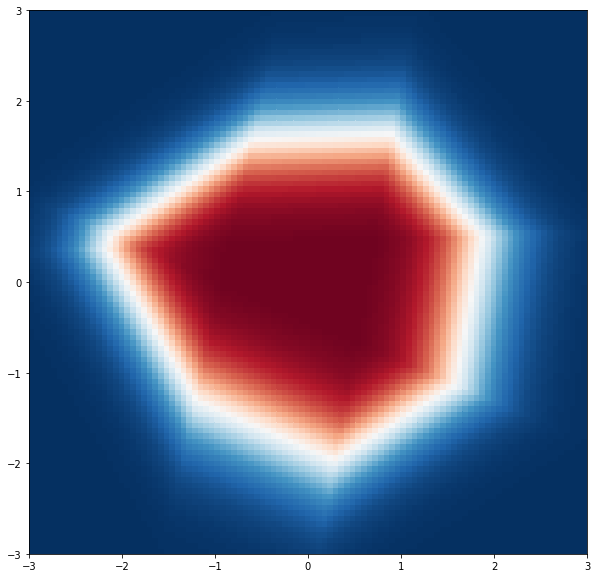

Epoch: 231 Loss: 0.311728298664093
Epoch: 232 Loss: 0.3307511508464813
Epoch: 233 Loss: 0.4537493586540222
Epoch: 234 Loss: 0.293161004781723
Epoch: 235 Loss: 0.27572640776634216
Epoch: 236 Loss: 0.36317113041877747
Epoch: 237 Loss: 0.26535993814468384
Epoch: 238 Loss: 0.35423192381858826
Epoch: 239 Loss: 0.271618127822876
Epoch: 240 Loss: 0.3170984983444214


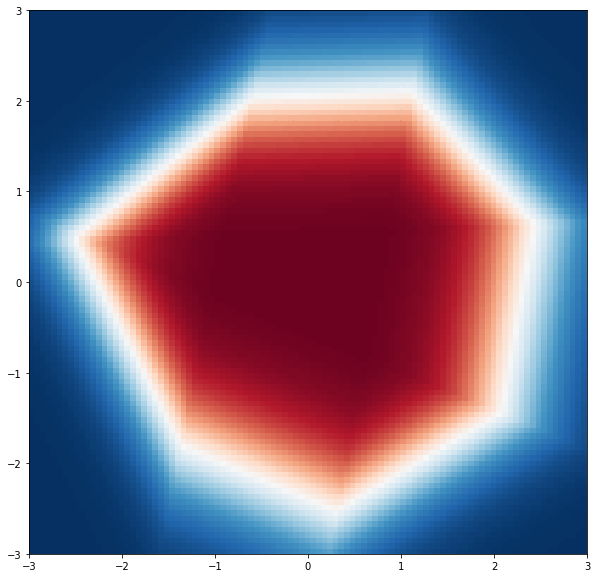

Epoch: 241 Loss: 0.3100441098213196
Epoch: 242 Loss: 0.4106769263744354
Epoch: 243 Loss: 0.2772945165634155
Epoch: 244 Loss: 0.2719726264476776
Epoch: 245 Loss: 0.2698556184768677
Epoch: 246 Loss: 0.2515179514884949
Epoch: 247 Loss: 0.2890850305557251
Epoch: 248 Loss: 0.25902649760246277
Epoch: 249 Loss: 0.3793739080429077
Epoch: 250 Loss: 0.2571382224559784


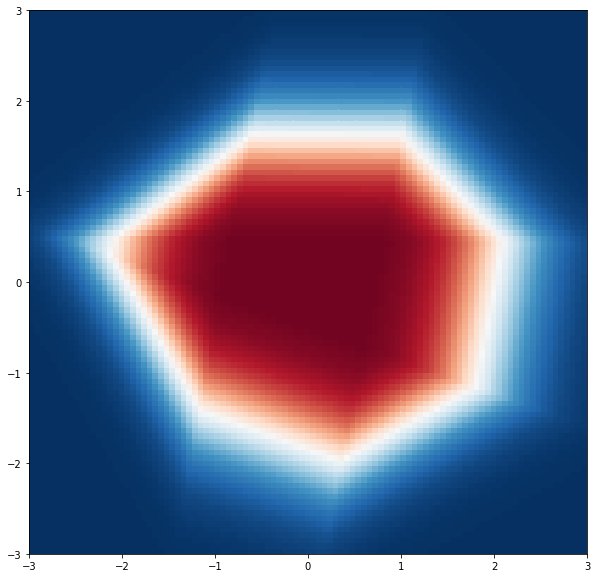

Epoch: 251 Loss: 0.2849590480327606
Epoch: 252 Loss: 0.3162037134170532
Epoch: 253 Loss: 0.4569820761680603
Epoch: 254 Loss: 0.2953232228755951
Epoch: 255 Loss: 0.29583731293678284
Epoch: 256 Loss: 0.3863799571990967
Epoch: 257 Loss: 0.24352645874023438
Epoch: 258 Loss: 0.2700042426586151
Epoch: 259 Loss: 0.2961260676383972
Epoch: 260 Loss: 0.4263934791088104


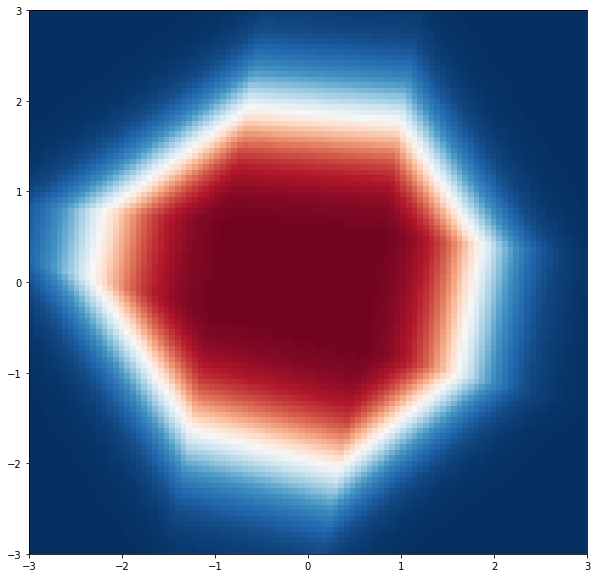

Epoch: 261 Loss: 0.2653450071811676
Epoch: 262 Loss: 0.26662883162498474
Epoch: 263 Loss: 0.3666331470012665
Epoch: 264 Loss: 0.24853834509849548
Epoch: 265 Loss: 0.30358684062957764
Epoch: 266 Loss: 0.30386316776275635
Epoch: 267 Loss: 0.41999173164367676
Epoch: 268 Loss: 0.2577167749404907
Epoch: 269 Loss: 0.2528414726257324
Epoch: 270 Loss: 0.32113128900527954


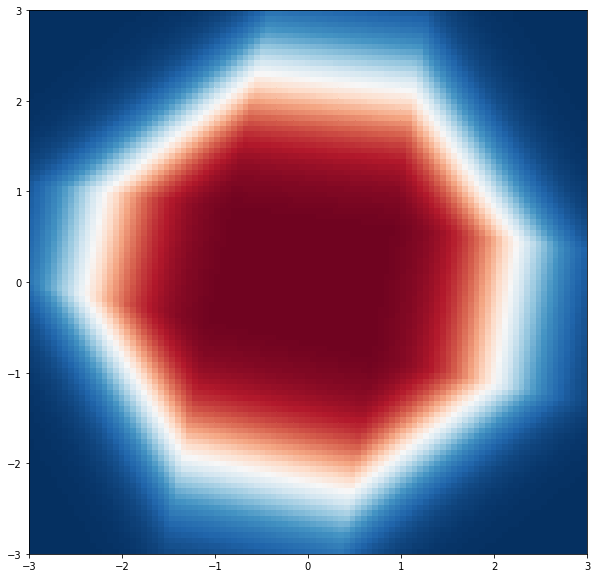

Epoch: 271 Loss: 0.2821047902107239
Epoch: 272 Loss: 0.40473055839538574
Epoch: 273 Loss: 0.23528966307640076
Epoch: 274 Loss: 0.23864509165287018
Epoch: 275 Loss: 0.2790631353855133
Epoch: 276 Loss: 0.29433611035346985
Epoch: 277 Loss: 0.42938652634620667
Epoch: 278 Loss: 0.2478175312280655
Epoch: 279 Loss: 0.2823638617992401
Epoch: 280 Loss: 0.4082987606525421


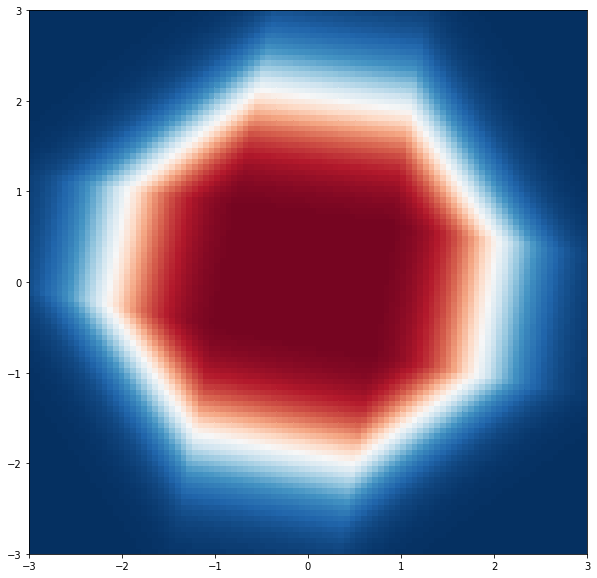

Epoch: 281 Loss: 0.23582294583320618
Epoch: 282 Loss: 0.2384985387325287
Epoch: 283 Loss: 0.2878721356391907
Epoch: 284 Loss: 0.30349811911582947
Epoch: 285 Loss: 0.44407689571380615
Epoch: 286 Loss: 0.2614087760448456
Epoch: 287 Loss: 0.3058154582977295
Epoch: 288 Loss: 0.4337754547595978
Epoch: 289 Loss: 0.2554134428501129
Epoch: 290 Loss: 0.2834995985031128


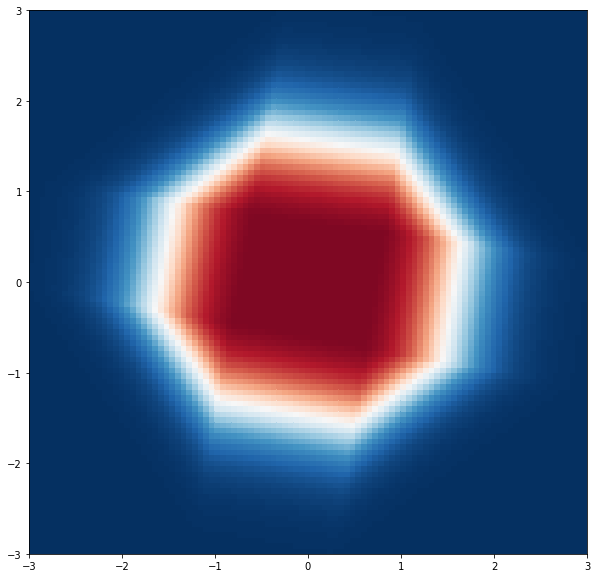

Epoch: 291 Loss: 0.4078322947025299
Epoch: 292 Loss: 0.23597919940948486
Epoch: 293 Loss: 0.249452605843544
Epoch: 294 Loss: 0.34643328189849854
Epoch: 295 Loss: 0.2543923854827881
Epoch: 296 Loss: 0.34807395935058594
Epoch: 297 Loss: 0.25022584199905396
Epoch: 298 Loss: 0.33602991700172424
Epoch: 299 Loss: 0.25801602005958557
Epoch: 300 Loss: 0.352988600730896


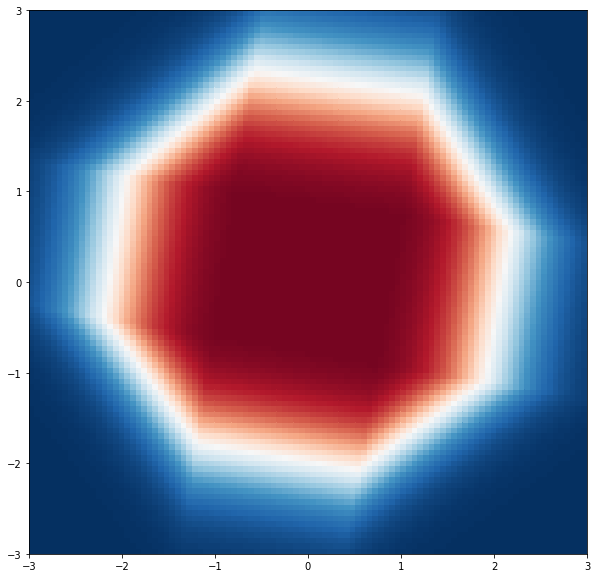

Epoch: 301 Loss: 0.25101199746131897
Epoch: 302 Loss: 0.28295987844467163
Epoch: 303 Loss: 0.27473902702331543
Epoch: 304 Loss: 0.3755521774291992
Epoch: 305 Loss: 0.24941056966781616
Epoch: 306 Loss: 0.25285494327545166
Epoch: 307 Loss: 0.2337942272424698
Epoch: 308 Loss: 0.2503475546836853
Epoch: 309 Loss: 0.281156450510025
Epoch: 310 Loss: 0.42897486686706543


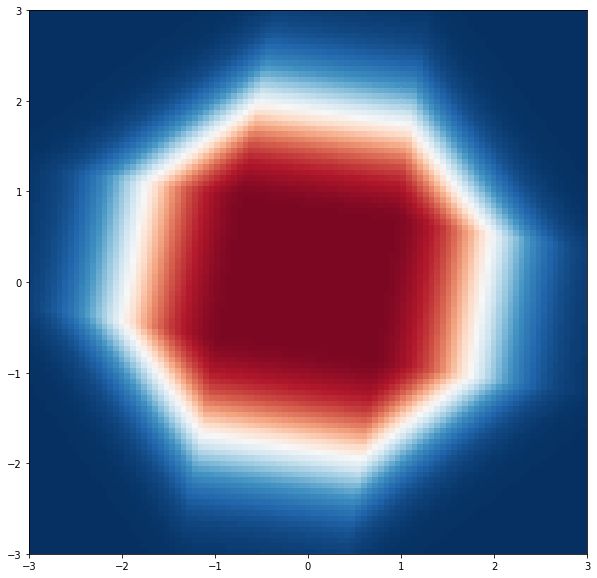

Epoch: 311 Loss: 0.24478720128536224
Epoch: 312 Loss: 0.29466935992240906
Epoch: 313 Loss: 0.4402032494544983
Epoch: 314 Loss: 0.2600558400154114
Epoch: 315 Loss: 0.2999088764190674
Epoch: 316 Loss: 0.4378911256790161
Epoch: 317 Loss: 0.26170116662979126
Epoch: 318 Loss: 0.2898074686527252
Epoch: 319 Loss: 0.41925230622291565
Epoch: 320 Loss: 0.2469848245382309


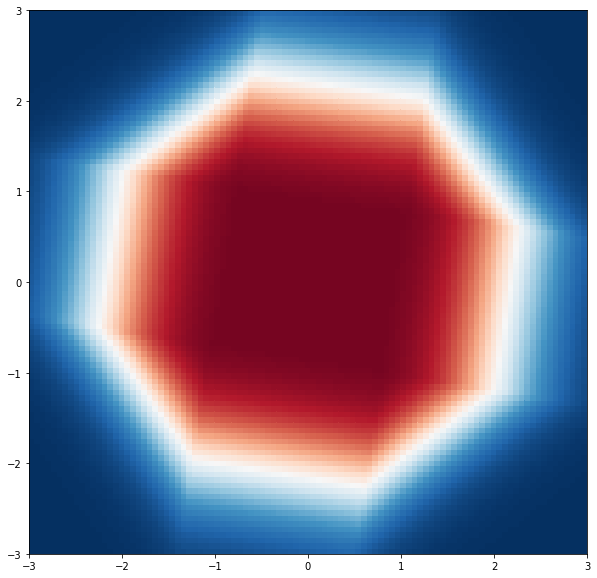

Epoch: 321 Loss: 0.27201712131500244
Epoch: 322 Loss: 0.40131518244743347
Epoch: 323 Loss: 0.2364439070224762
Epoch: 324 Loss: 0.25049981474876404
Epoch: 325 Loss: 0.34920424222946167
Epoch: 326 Loss: 0.2376900464296341
Epoch: 327 Loss: 0.27457165718078613
Epoch: 328 Loss: 0.294765442609787
Epoch: 329 Loss: 0.4294315278530121
Epoch: 330 Loss: 0.25584226846694946


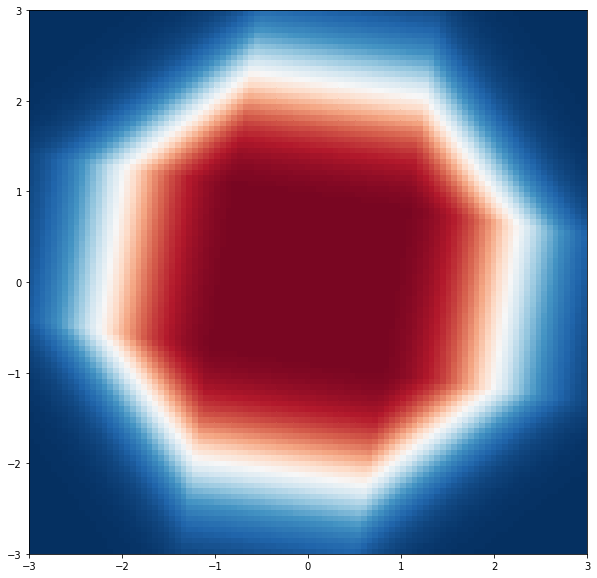

Epoch: 331 Loss: 0.2709682881832123
Epoch: 332 Loss: 0.399135947227478
Epoch: 333 Loss: 0.23562927544116974
Epoch: 334 Loss: 0.24560485780239105
Epoch: 335 Loss: 0.32914936542510986
Epoch: 336 Loss: 0.2581775188446045
Epoch: 337 Loss: 0.37060126662254333
Epoch: 338 Loss: 0.23367547988891602
Epoch: 339 Loss: 0.2351241111755371
Epoch: 340 Loss: 0.23109747469425201


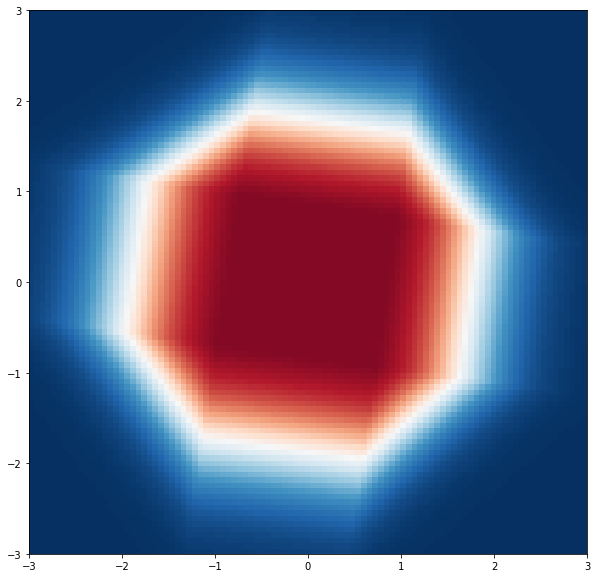

Epoch: 341 Loss: 0.2589302659034729
Epoch: 342 Loss: 0.2904456853866577
Epoch: 343 Loss: 0.4443923532962799
Epoch: 344 Loss: 0.2663531005382538
Epoch: 345 Loss: 0.3111901581287384
Epoch: 346 Loss: 0.45357686281204224
Epoch: 347 Loss: 0.28583815693855286
Epoch: 348 Loss: 0.28418150544166565
Epoch: 349 Loss: 0.41123542189598083
Epoch: 350 Loss: 0.2457258105278015


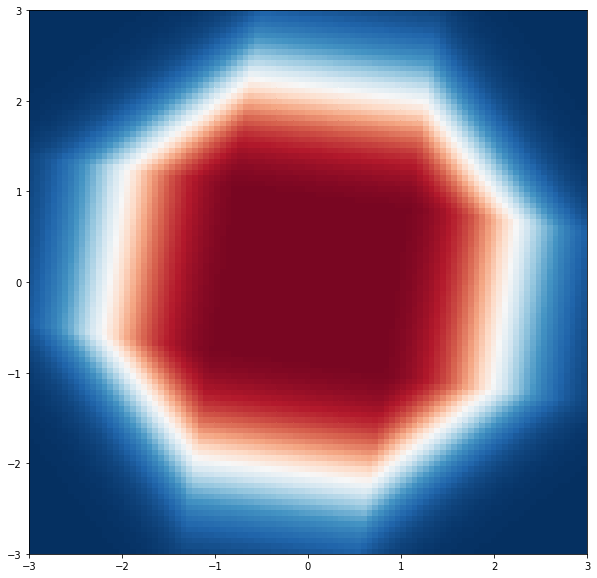

Epoch: 351 Loss: 0.25913572311401367
Epoch: 352 Loss: 0.3689587712287903
Epoch: 353 Loss: 0.23088620603084564
Epoch: 354 Loss: 0.2282959371805191
Epoch: 355 Loss: 0.22574573755264282
Epoch: 356 Loss: 0.22594581544399261
Epoch: 357 Loss: 0.2262396365404129
Epoch: 358 Loss: 0.2541271150112152
Epoch: 359 Loss: 0.2956506609916687
Epoch: 360 Loss: 0.46515023708343506


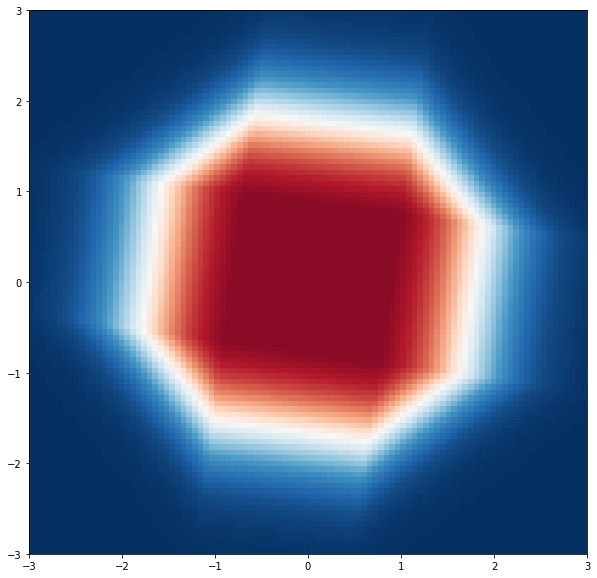

Epoch: 361 Loss: 0.29204580187797546
Epoch: 362 Loss: 0.31185147166252136
Epoch: 363 Loss: 0.46132415533065796
Epoch: 364 Loss: 0.2956385314464569
Epoch: 365 Loss: 0.2851006090641022
Epoch: 366 Loss: 0.42125701904296875
Epoch: 367 Loss: 0.2527344226837158
Epoch: 368 Loss: 0.2719295918941498
Epoch: 369 Loss: 0.40117812156677246
Epoch: 370 Loss: 0.24008558690547943


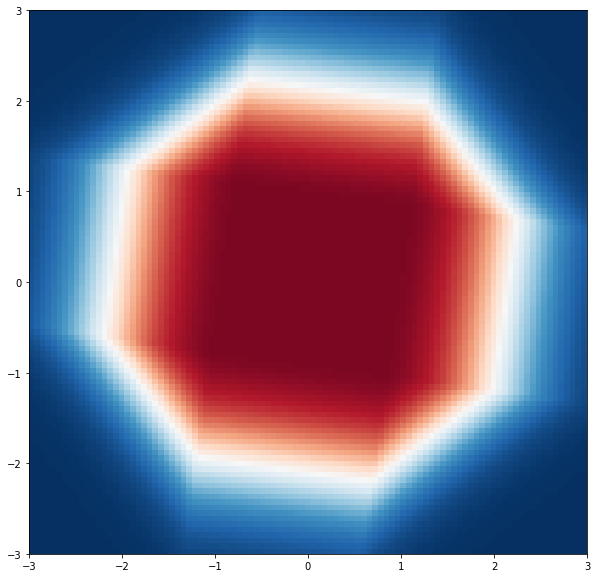

Epoch: 371 Loss: 0.2557987868785858
Epoch: 372 Loss: 0.360037624835968
Epoch: 373 Loss: 0.22977520525455475
Epoch: 374 Loss: 0.2304776906967163
Epoch: 375 Loss: 0.23987695574760437
Epoch: 376 Loss: 0.32317647337913513
Epoch: 377 Loss: 0.2652355432510376
Epoch: 378 Loss: 0.39644190669059753
Epoch: 379 Loss: 0.23222249746322632
Epoch: 380 Loss: 0.243928924202919


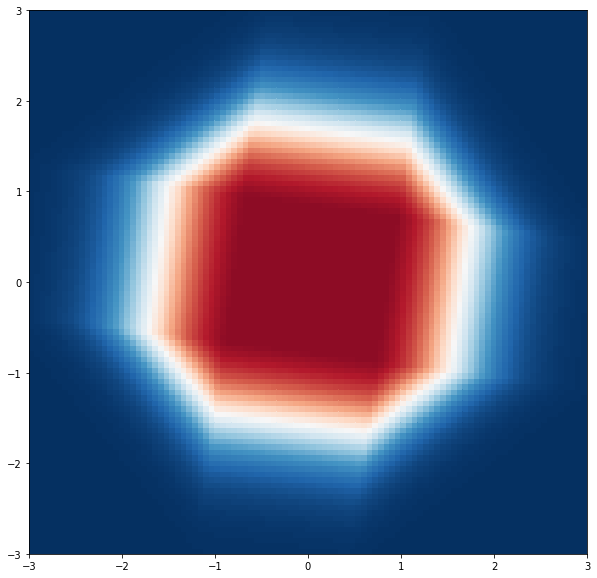

Epoch: 381 Loss: 0.3376622498035431
Epoch: 382 Loss: 0.24688401818275452
Epoch: 383 Loss: 0.34079092741012573
Epoch: 384 Loss: 0.25283628702163696
Epoch: 385 Loss: 0.30148258805274963
Epoch: 386 Loss: 0.2814001739025116
Epoch: 387 Loss: 0.32166722416877747
Epoch: 388 Loss: 0.2801629304885864
Epoch: 389 Loss: 0.2992823123931885
Epoch: 390 Loss: 0.27757155895233154


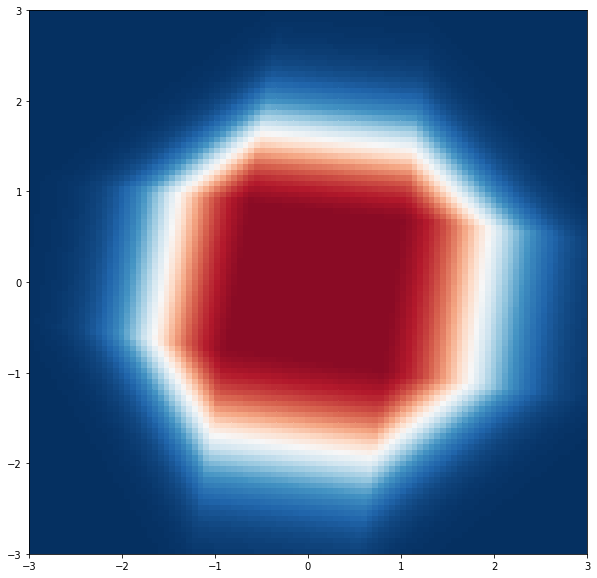

Epoch: 391 Loss: 0.3096970319747925
Epoch: 392 Loss: 0.28028401732444763
Epoch: 393 Loss: 0.3054555654525757
Epoch: 394 Loss: 0.2863882780075073
Epoch: 395 Loss: 0.3160277307033539
Epoch: 396 Loss: 0.2851716876029968
Epoch: 397 Loss: 0.3039592504501343
Epoch: 398 Loss: 0.28527525067329407
Epoch: 399 Loss: 0.3131074607372284
Epoch: 400 Loss: 0.2842792272567749


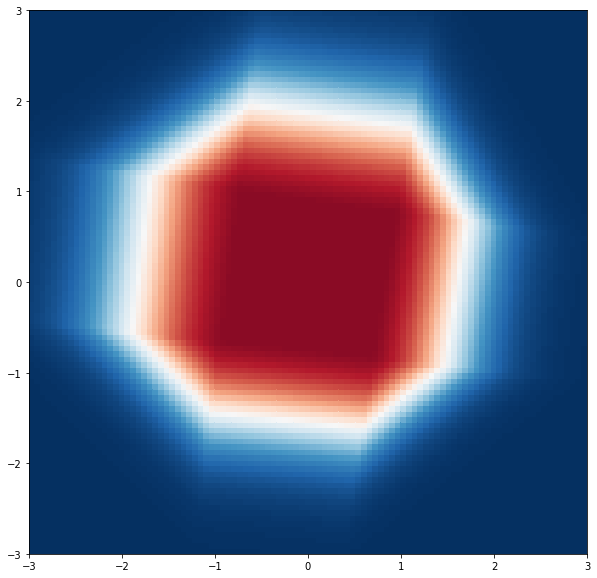

Epoch: 401 Loss: 0.30717718601226807
Epoch: 402 Loss: 0.28903257846832275
Epoch: 403 Loss: 0.31197524070739746
Epoch: 404 Loss: 0.28261807560920715
Epoch: 405 Loss: 0.30758336186408997
Epoch: 406 Loss: 0.2903901934623718
Epoch: 407 Loss: 0.3113242983818054
Epoch: 408 Loss: 0.2820383608341217
Epoch: 409 Loss: 0.3080044090747833
Epoch: 410 Loss: 0.2879335284233093


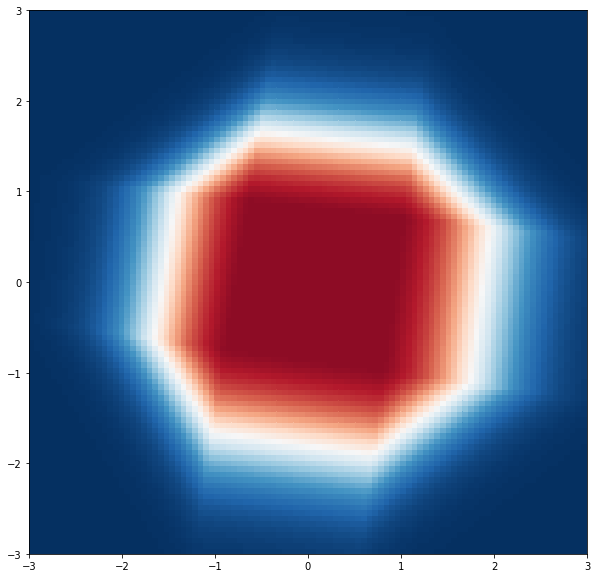

Epoch: 411 Loss: 0.30840665102005005
Epoch: 412 Loss: 0.2806047797203064
Epoch: 413 Loss: 0.3094610571861267
Epoch: 414 Loss: 0.2892487049102783
Epoch: 415 Loss: 0.30798909068107605
Epoch: 416 Loss: 0.28265509009361267
Epoch: 417 Loss: 0.30744704604148865
Epoch: 418 Loss: 0.28494539856910706
Epoch: 419 Loss: 0.307930588722229
Epoch: 420 Loss: 0.27945858240127563


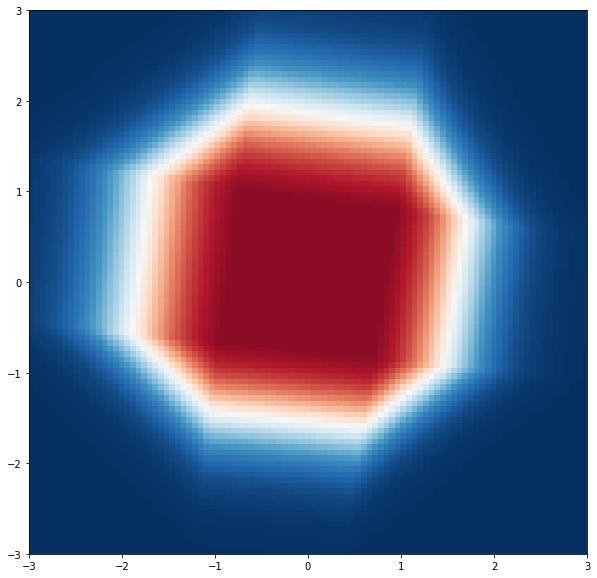

Epoch: 421 Loss: 0.30773258209228516
Epoch: 422 Loss: 0.28859829902648926
Epoch: 423 Loss: 0.30981436371803284
Epoch: 424 Loss: 0.2864118814468384
Epoch: 425 Loss: 0.30775517225265503
Epoch: 426 Loss: 0.29118311405181885
Epoch: 427 Loss: 0.3109380900859833
Epoch: 428 Loss: 0.2848464250564575
Epoch: 429 Loss: 0.3073590397834778
Epoch: 430 Loss: 0.2859106659889221


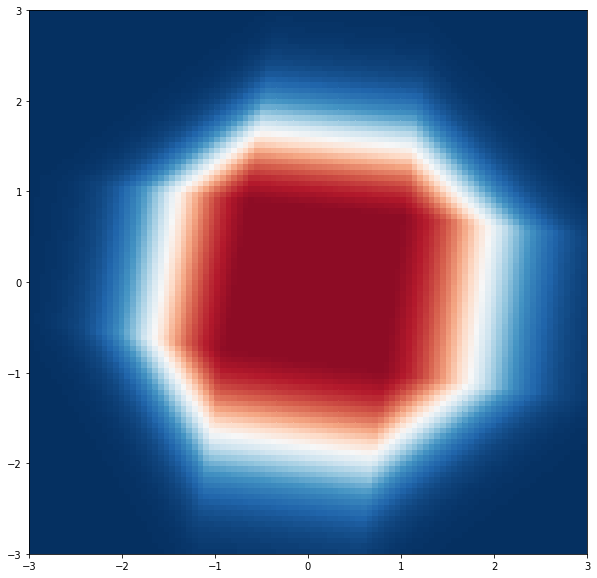

Epoch: 431 Loss: 0.3078314960002899
Epoch: 432 Loss: 0.2807573080062866
Epoch: 433 Loss: 0.305703341960907
Epoch: 434 Loss: 0.2833217680454254
Epoch: 435 Loss: 0.3079346716403961
Epoch: 436 Loss: 0.28092721104621887
Epoch: 437 Loss: 0.3073306083679199
Epoch: 438 Loss: 0.2902173697948456
Epoch: 439 Loss: 0.31021741032600403
Epoch: 440 Loss: 0.2871030569076538


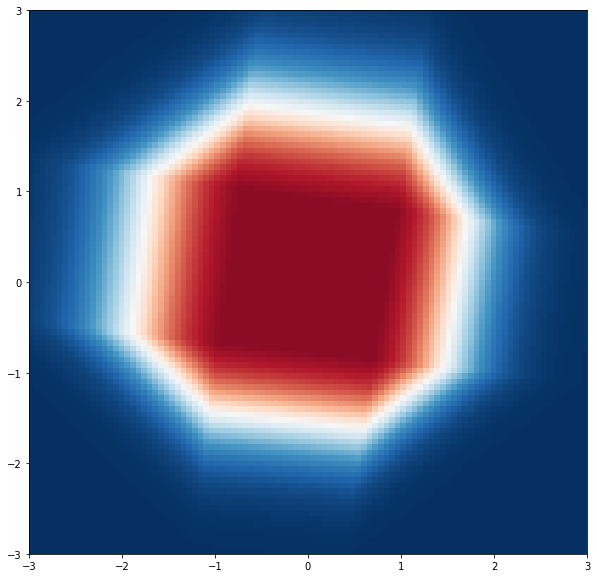

Epoch: 441 Loss: 0.3055620491504669
Epoch: 442 Loss: 0.28486016392707825
Epoch: 443 Loss: 0.3082645535469055
Epoch: 444 Loss: 0.28186216950416565
Epoch: 445 Loss: 0.30535149574279785
Epoch: 446 Loss: 0.28333547711372375
Epoch: 447 Loss: 0.3067854642868042
Epoch: 448 Loss: 0.28234776854515076
Epoch: 449 Loss: 0.3081479072570801
Epoch: 450 Loss: 0.2914981544017792


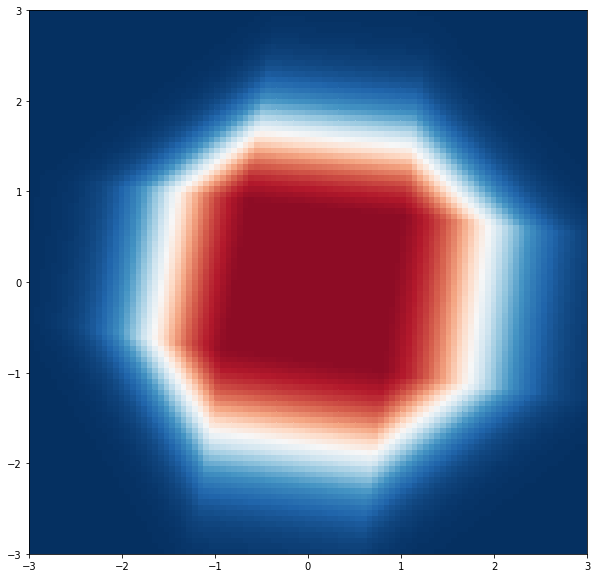

Epoch: 451 Loss: 0.3080081343650818
Epoch: 452 Loss: 0.28164559602737427
Epoch: 453 Loss: 0.3086563050746918
Epoch: 454 Loss: 0.2874383330345154
Epoch: 455 Loss: 0.30639076232910156
Epoch: 456 Loss: 0.28112006187438965
Epoch: 457 Loss: 0.308137983083725
Epoch: 458 Loss: 0.2845538258552551
Epoch: 459 Loss: 0.30435892939567566
Epoch: 460 Loss: 0.28474757075309753


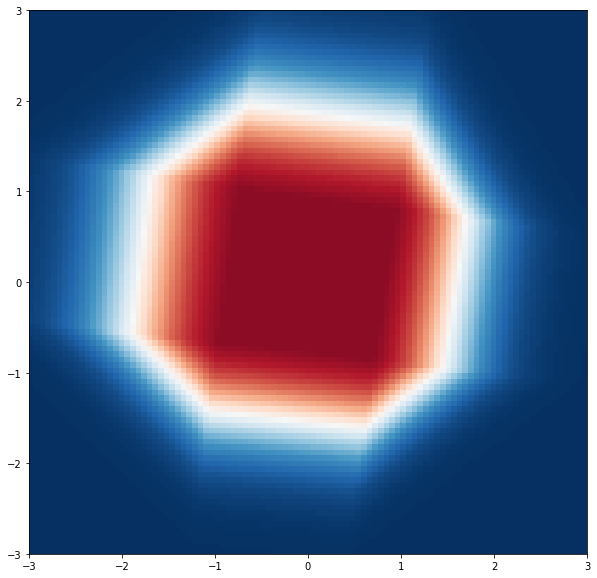

Epoch: 461 Loss: 0.3068278431892395
Epoch: 462 Loss: 0.28321096301078796
Epoch: 463 Loss: 0.30416643619537354
Epoch: 464 Loss: 0.2854804992675781
Epoch: 465 Loss: 0.30872586369514465
Epoch: 466 Loss: 0.2875845432281494
Epoch: 467 Loss: 0.30668172240257263
Epoch: 468 Loss: 0.28175318241119385
Epoch: 469 Loss: 0.3085422217845917
Epoch: 470 Loss: 0.29062220454216003


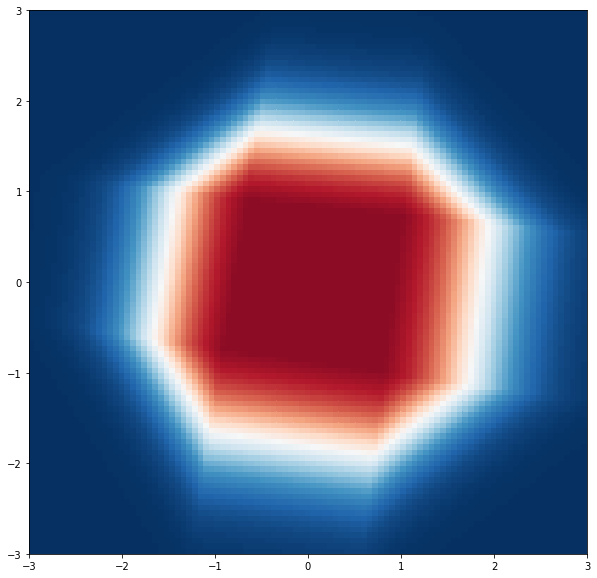

Epoch: 471 Loss: 0.3053787648677826
Epoch: 472 Loss: 0.2817856967449188
Epoch: 473 Loss: 0.30803433060646057
Epoch: 474 Loss: 0.2828405499458313
Epoch: 475 Loss: 0.303642213344574
Epoch: 476 Loss: 0.2846897840499878
Epoch: 477 Loss: 0.3087669312953949
Epoch: 478 Loss: 0.2878877520561218
Epoch: 479 Loss: 0.30574262142181396
Epoch: 480 Loss: 0.2821098268032074


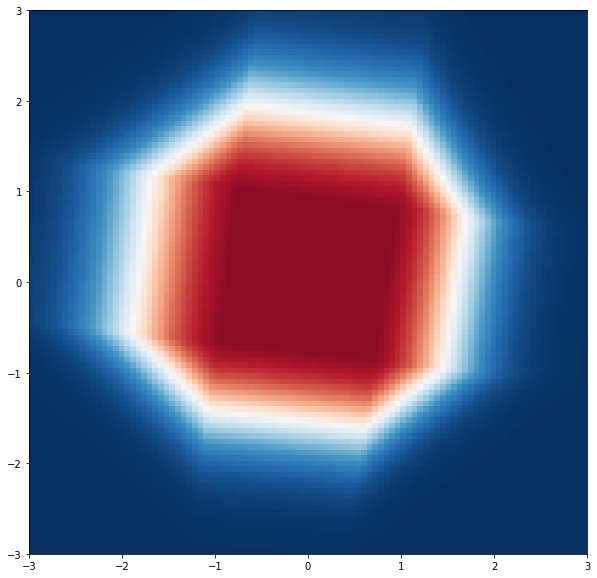

Epoch: 481 Loss: 0.30699923634529114
Epoch: 482 Loss: 0.28162604570388794
Epoch: 483 Loss: 0.301390677690506
Epoch: 484 Loss: 0.28473517298698425
Epoch: 485 Loss: 0.3074798583984375
Epoch: 486 Loss: 0.2846824526786804
Epoch: 487 Loss: 0.3038971424102783
Epoch: 488 Loss: 0.2841090261936188
Epoch: 489 Loss: 0.3070669174194336
Epoch: 490 Loss: 0.28121477365493774


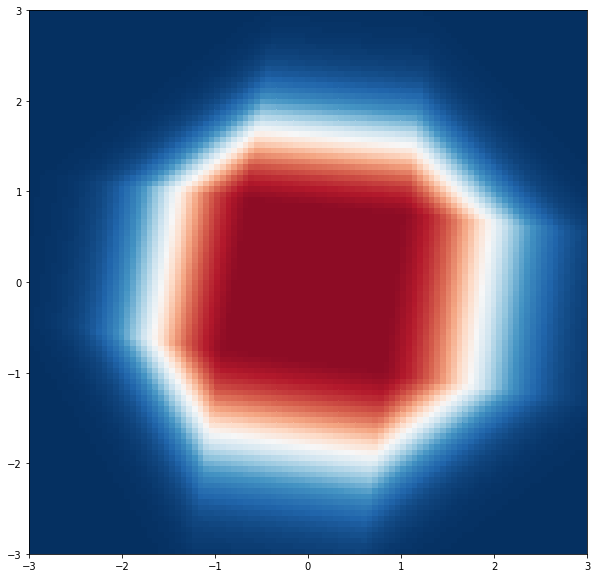

Epoch: 491 Loss: 0.3023647367954254
Epoch: 492 Loss: 0.28512275218963623
Epoch: 493 Loss: 0.30822786688804626
Epoch: 494 Loss: 0.28409817814826965
Epoch: 495 Loss: 0.3040829002857208
Epoch: 496 Loss: 0.28486430644989014
Epoch: 497 Loss: 0.3070085048675537
Epoch: 498 Loss: 0.2852235436439514
Epoch: 499 Loss: 0.30574527382850647
Epoch: 500 Loss: 0.28276753425598145


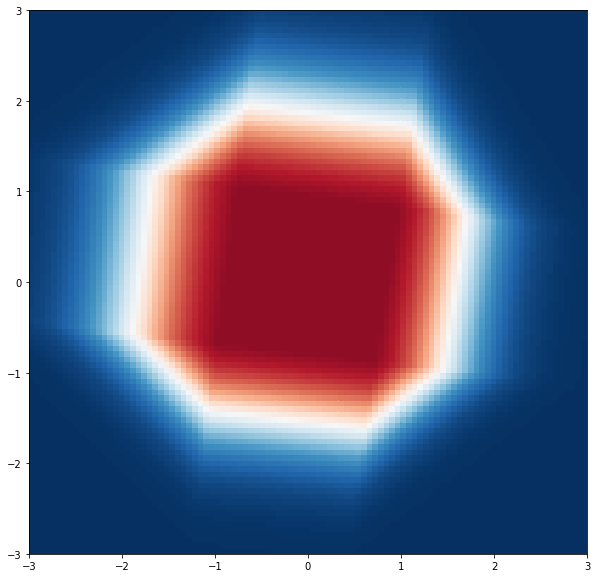

Epoch: 501 Loss: 0.3071678876876831
Epoch: 502 Loss: 0.2856346368789673
Epoch: 503 Loss: 0.30406108498573303
Epoch: 504 Loss: 0.2828822433948517
Epoch: 505 Loss: 0.3075349032878876
Epoch: 506 Loss: 0.28609657287597656
Epoch: 507 Loss: 0.3030264675617218
Epoch: 508 Loss: 0.2823227643966675
Epoch: 509 Loss: 0.3075030744075775
Epoch: 510 Loss: 0.28240567445755005


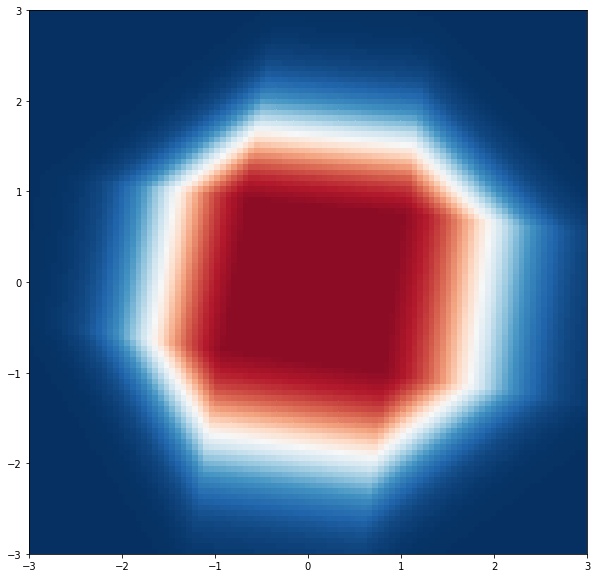

Epoch: 511 Loss: 0.3007825016975403
Epoch: 512 Loss: 0.28518831729888916
Epoch: 513 Loss: 0.3062921166419983
Epoch: 514 Loss: 0.27893149852752686
Epoch: 515 Loss: 0.2980630099773407
Epoch: 516 Loss: 0.2836311459541321
Epoch: 517 Loss: 0.31003043055534363
Epoch: 518 Loss: 0.2901725172996521
Epoch: 519 Loss: 0.2996557950973511
Epoch: 520 Loss: 0.2846676707267761


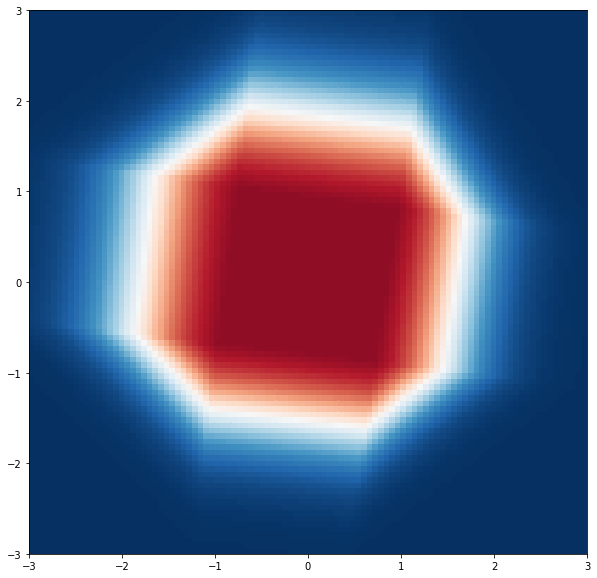

Epoch: 521 Loss: 0.31443682312965393
Epoch: 522 Loss: 0.28392094373703003
Epoch: 523 Loss: 0.2984412908554077
Epoch: 524 Loss: 0.28604352474212646
Epoch: 525 Loss: 0.31230658292770386
Epoch: 526 Loss: 0.281150758266449
Epoch: 527 Loss: 0.3010590970516205
Epoch: 528 Loss: 0.28646284341812134
Epoch: 529 Loss: 0.3091185688972473
Epoch: 530 Loss: 0.2835555374622345


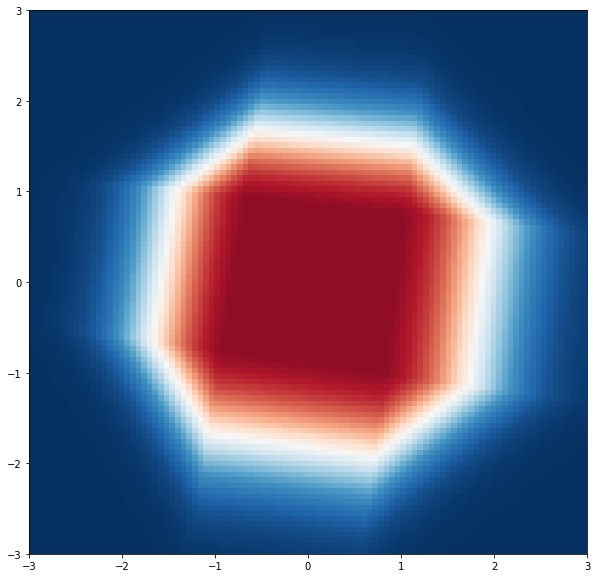

Epoch: 531 Loss: 0.3007820248603821
Epoch: 532 Loss: 0.2841557264328003
Epoch: 533 Loss: 0.3066900670528412
Epoch: 534 Loss: 0.2836496829986572
Epoch: 535 Loss: 0.3029276132583618
Epoch: 536 Loss: 0.2845649719238281
Epoch: 537 Loss: 0.30879220366477966
Epoch: 538 Loss: 0.28534993529319763
Epoch: 539 Loss: 0.30127453804016113
Epoch: 540 Loss: 0.28254687786102295


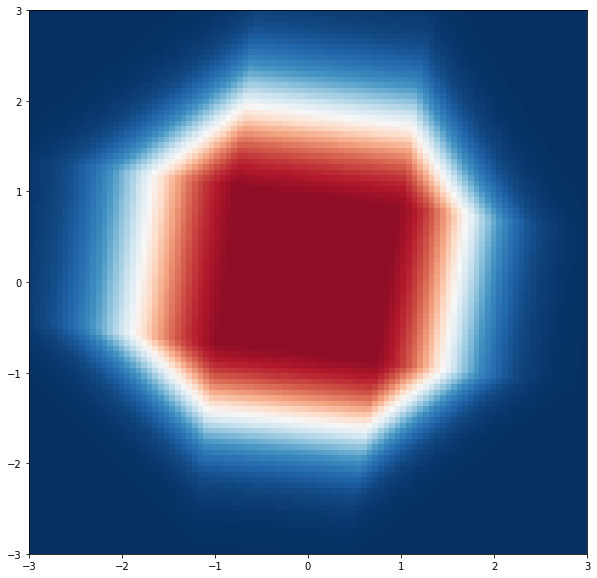

Epoch: 541 Loss: 0.3080241084098816
Epoch: 542 Loss: 0.2849727272987366
Epoch: 543 Loss: 0.3003014028072357
Epoch: 544 Loss: 0.2836817800998688
Epoch: 545 Loss: 0.3080712556838989
Epoch: 546 Loss: 0.28642719984054565
Epoch: 547 Loss: 0.30481621623039246
Epoch: 548 Loss: 0.2847853899002075
Epoch: 549 Loss: 0.308464914560318
Epoch: 550 Loss: 0.2834518551826477


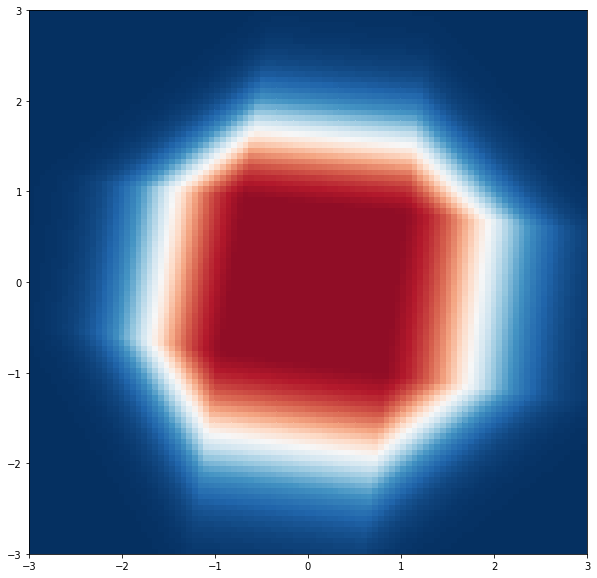

Epoch: 551 Loss: 0.3003872036933899
Epoch: 552 Loss: 0.28128117322921753
Epoch: 553 Loss: 0.3085140287876129
Epoch: 554 Loss: 0.2858741581439972
Epoch: 555 Loss: 0.3030661642551422
Epoch: 556 Loss: 0.28567540645599365
Epoch: 557 Loss: 0.30886945128440857
Epoch: 558 Loss: 0.28199613094329834
Epoch: 559 Loss: 0.29962706565856934
Epoch: 560 Loss: 0.2825472950935364


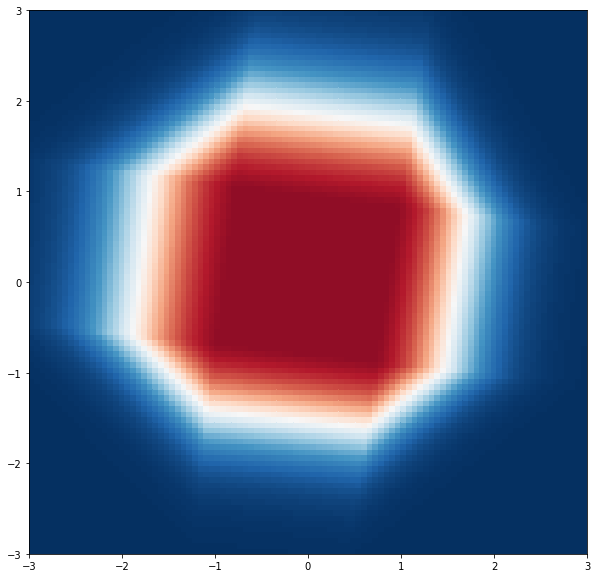

Epoch: 561 Loss: 0.3075927197933197
Epoch: 562 Loss: 0.28223419189453125
Epoch: 563 Loss: 0.2979576587677002
Epoch: 564 Loss: 0.2809639573097229
Epoch: 565 Loss: 0.3085215985774994
Epoch: 566 Loss: 0.28266945481300354
Epoch: 567 Loss: 0.29667413234710693
Epoch: 568 Loss: 0.28121069073677063
Epoch: 569 Loss: 0.3083326518535614
Epoch: 570 Loss: 0.28380995988845825


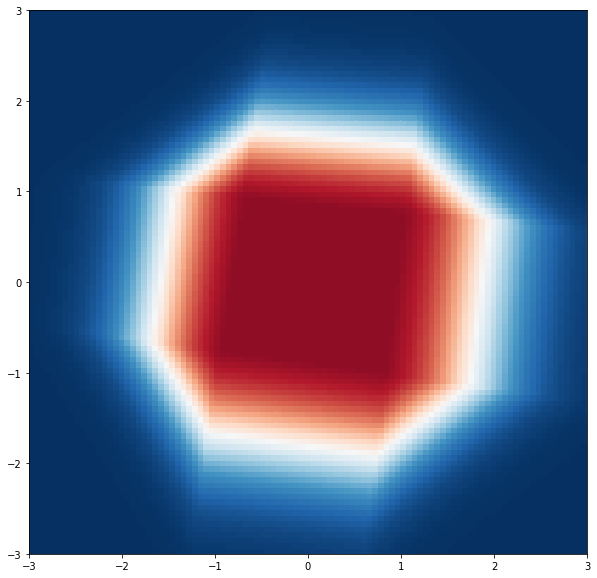

Epoch: 571 Loss: 0.3001524806022644
Epoch: 572 Loss: 0.2855478525161743
Epoch: 573 Loss: 0.3089542090892792
Epoch: 574 Loss: 0.2831738591194153
Epoch: 575 Loss: 0.2986813485622406
Epoch: 576 Loss: 0.2844284474849701
Epoch: 577 Loss: 0.3127291798591614
Epoch: 578 Loss: 0.27875542640686035
Epoch: 579 Loss: 0.298645943403244
Epoch: 580 Loss: 0.2822933495044708


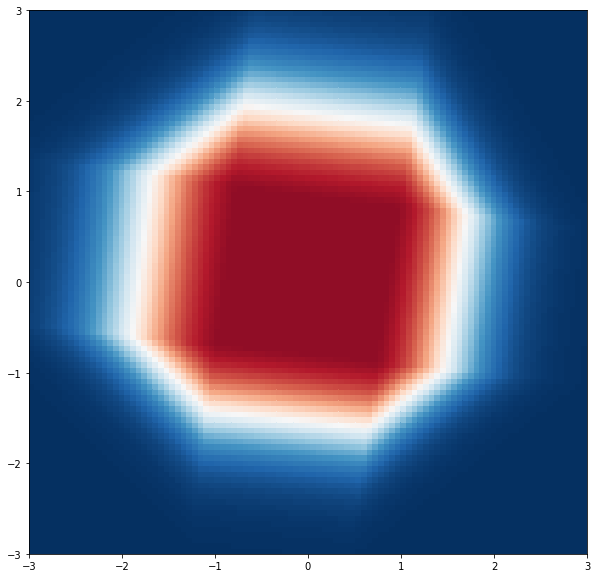

Epoch: 581 Loss: 0.30556368827819824
Epoch: 582 Loss: 0.2827710509300232
Epoch: 583 Loss: 0.30074429512023926
Epoch: 584 Loss: 0.2861871123313904
Epoch: 585 Loss: 0.3087012469768524
Epoch: 586 Loss: 0.28129178285598755
Epoch: 587 Loss: 0.2993491291999817
Epoch: 588 Loss: 0.2855185270309448
Epoch: 589 Loss: 0.3089783787727356
Epoch: 590 Loss: 0.2808675467967987


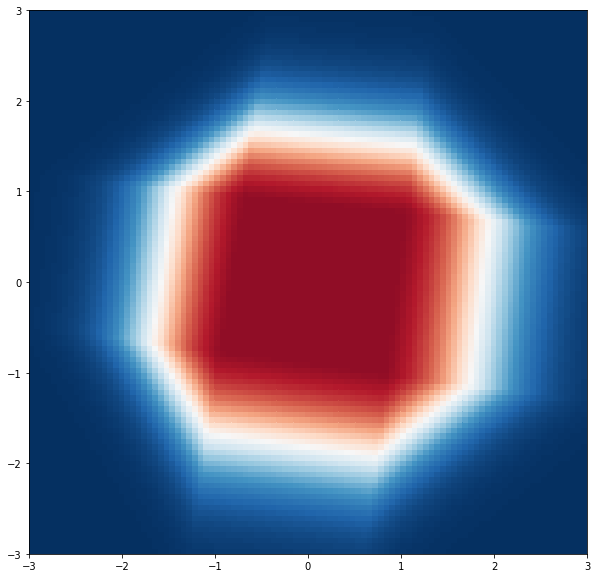

Epoch: 591 Loss: 0.2990294396877289
Epoch: 592 Loss: 0.2862064242362976
Epoch: 593 Loss: 0.310198575258255
Epoch: 594 Loss: 0.277464896440506
Epoch: 595 Loss: 0.3002225160598755
Epoch: 596 Loss: 0.2854539155960083
Epoch: 597 Loss: 0.30759307742118835
Epoch: 598 Loss: 0.28327521681785583
Epoch: 599 Loss: 0.3039039671421051
Epoch: 600 Loss: 0.2848093509674072


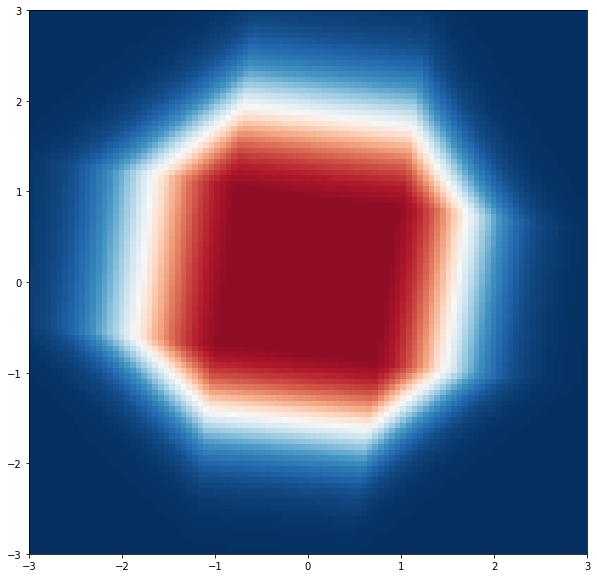

Epoch: 601 Loss: 0.30722588300704956
Epoch: 602 Loss: 0.28299540281295776
Epoch: 603 Loss: 0.3006991147994995
Epoch: 604 Loss: 0.2839573323726654
Epoch: 605 Loss: 0.3109389543533325
Epoch: 606 Loss: 0.27606600522994995
Epoch: 607 Loss: 0.298188179731369
Epoch: 608 Loss: 0.2812950909137726
Epoch: 609 Loss: 0.30460914969444275
Epoch: 610 Loss: 0.28263264894485474


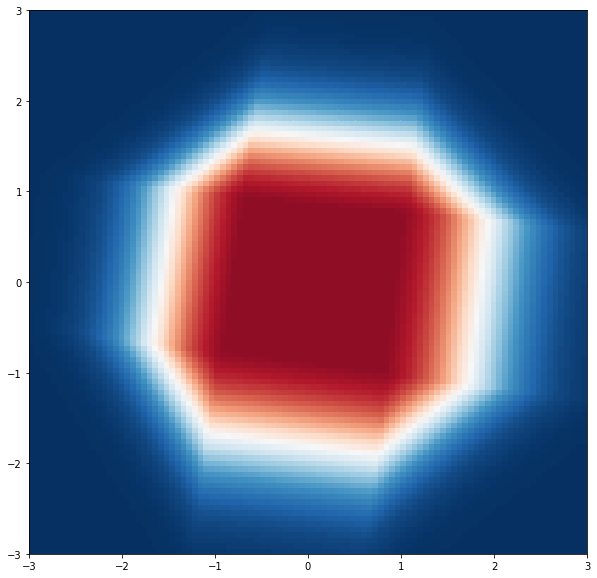

Epoch: 611 Loss: 0.30272629857063293
Epoch: 612 Loss: 0.2857426106929779
Epoch: 613 Loss: 0.31014201045036316
Epoch: 614 Loss: 0.2749845087528229
Epoch: 615 Loss: 0.2989750802516937
Epoch: 616 Loss: 0.28103846311569214
Epoch: 617 Loss: 0.30332404375076294
Epoch: 618 Loss: 0.2835509777069092
Epoch: 619 Loss: 0.30406033992767334
Epoch: 620 Loss: 0.2825171947479248


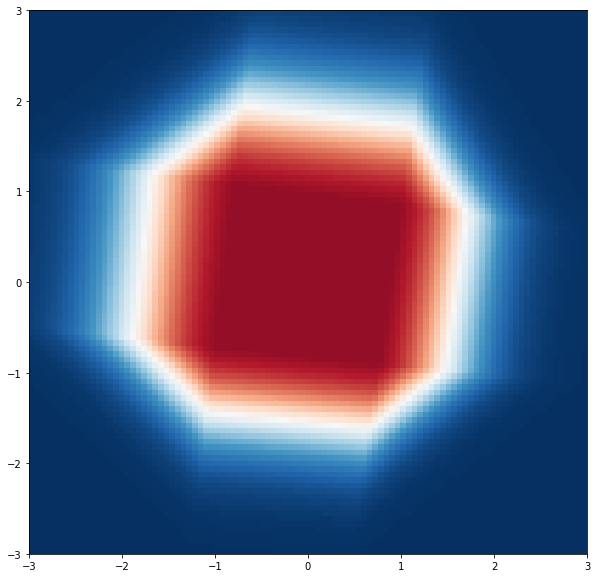

Epoch: 621 Loss: 0.3050140142440796
Epoch: 622 Loss: 0.283414751291275
Epoch: 623 Loss: 0.30577924847602844
Epoch: 624 Loss: 0.27971670031547546
Epoch: 625 Loss: 0.30309444665908813
Epoch: 626 Loss: 0.2820894718170166
Epoch: 627 Loss: 0.3012532591819763
Epoch: 628 Loss: 0.2840695083141327
Epoch: 629 Loss: 0.306104451417923
Epoch: 630 Loss: 0.2847174108028412


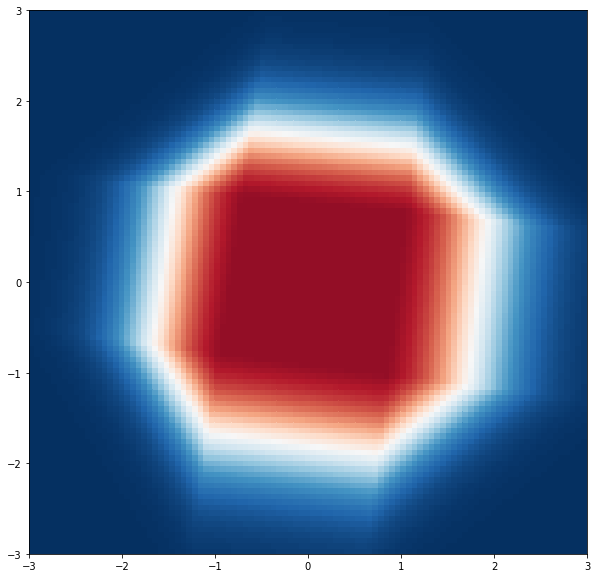

Epoch: 631 Loss: 0.30461427569389343
Epoch: 632 Loss: 0.2858622074127197
Epoch: 633 Loss: 0.30670058727264404
Epoch: 634 Loss: 0.2802410423755646
Epoch: 635 Loss: 0.30560120940208435
Epoch: 636 Loss: 0.2837565541267395
Epoch: 637 Loss: 0.3056313991546631
Epoch: 638 Loss: 0.2831666171550751
Epoch: 639 Loss: 0.3032941520214081
Epoch: 640 Loss: 0.2816561162471771


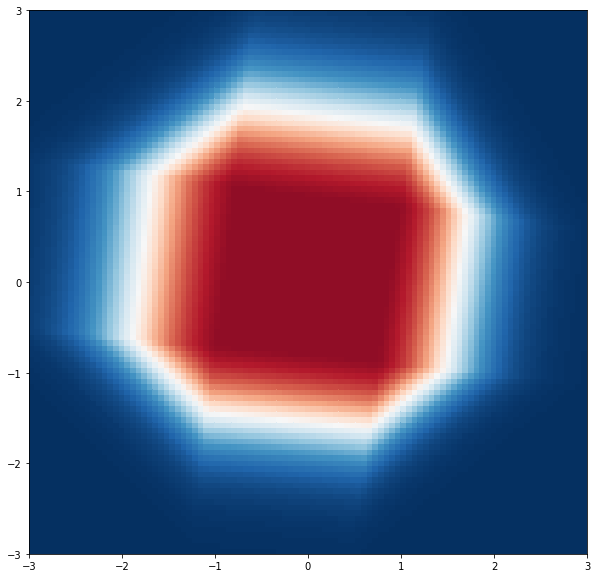

Epoch: 641 Loss: 0.30539843440055847
Epoch: 642 Loss: 0.27961108088493347
Epoch: 643 Loss: 0.30363717675209045
Epoch: 644 Loss: 0.28370264172554016
Epoch: 645 Loss: 0.3021731972694397
Epoch: 646 Loss: 0.28019797801971436
Epoch: 647 Loss: 0.3026530146598816
Epoch: 648 Loss: 0.28405308723449707
Epoch: 649 Loss: 0.3045816123485565
Epoch: 650 Loss: 0.2850540280342102


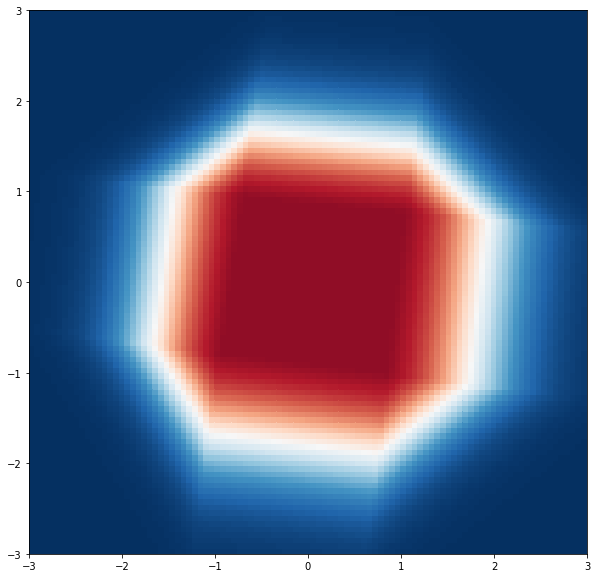

Epoch: 651 Loss: 0.3038889169692993
Epoch: 652 Loss: 0.28336194157600403
Epoch: 653 Loss: 0.3050491213798523
Epoch: 654 Loss: 0.28289660811424255
Epoch: 655 Loss: 0.3059908151626587
Epoch: 656 Loss: 0.279578298330307
Epoch: 657 Loss: 0.3029809594154358
Epoch: 658 Loss: 0.28186410665512085
Epoch: 659 Loss: 0.30000486969947815
Epoch: 660 Loss: 0.28248733282089233


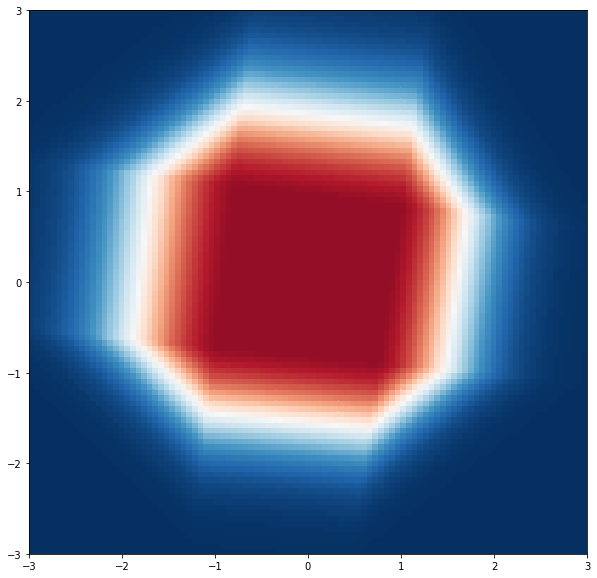

Epoch: 661 Loss: 0.304900586605072
Epoch: 662 Loss: 0.279466450214386
Epoch: 663 Loss: 0.30114981532096863
Epoch: 664 Loss: 0.28174281120300293
Epoch: 665 Loss: 0.3011553883552551
Epoch: 666 Loss: 0.28244277834892273
Epoch: 667 Loss: 0.3037211298942566
Epoch: 668 Loss: 0.2804744243621826
Epoch: 669 Loss: 0.3042077422142029
Epoch: 670 Loss: 0.28127774596214294


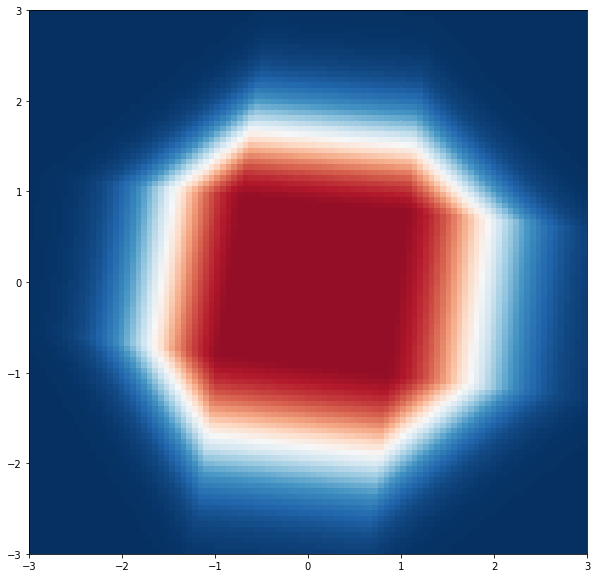

Epoch: 671 Loss: 0.30063655972480774
Epoch: 672 Loss: 0.28300219774246216
Epoch: 673 Loss: 0.3039102256298065
Epoch: 674 Loss: 0.2829116880893707
Epoch: 675 Loss: 0.3030688464641571
Epoch: 676 Loss: 0.28171616792678833
Epoch: 677 Loss: 0.30617567896842957
Epoch: 678 Loss: 0.2799334228038788
Epoch: 679 Loss: 0.30199533700942993
Epoch: 680 Loss: 0.28627121448516846


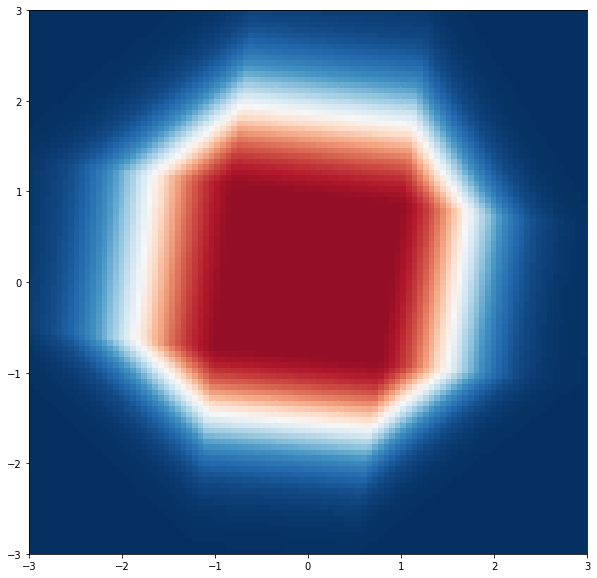

Epoch: 681 Loss: 0.30390897393226624
Epoch: 682 Loss: 0.28212958574295044
Epoch: 683 Loss: 0.3041572868824005
Epoch: 684 Loss: 0.28391098976135254
Epoch: 685 Loss: 0.3070222735404968
Epoch: 686 Loss: 0.2787896990776062
Epoch: 687 Loss: 0.30280718207359314
Epoch: 688 Loss: 0.2827993631362915
Epoch: 689 Loss: 0.3001057505607605
Epoch: 690 Loss: 0.2849169075489044


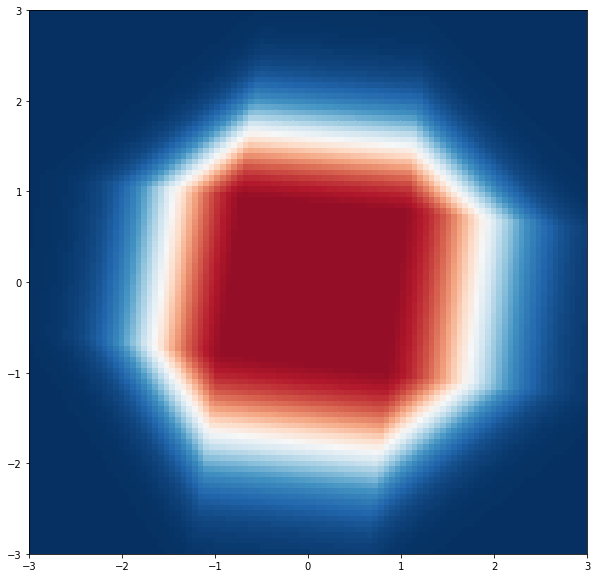

Epoch: 691 Loss: 0.3088853359222412
Epoch: 692 Loss: 0.27866023778915405
Epoch: 693 Loss: 0.3005951941013336
Epoch: 694 Loss: 0.28296899795532227
Epoch: 695 Loss: 0.3018418550491333
Epoch: 696 Loss: 0.28214913606643677
Epoch: 697 Loss: 0.30222779512405396
Epoch: 698 Loss: 0.28341835737228394
Epoch: 699 Loss: 0.30415409803390503
Epoch: 700 Loss: 0.2797700762748718


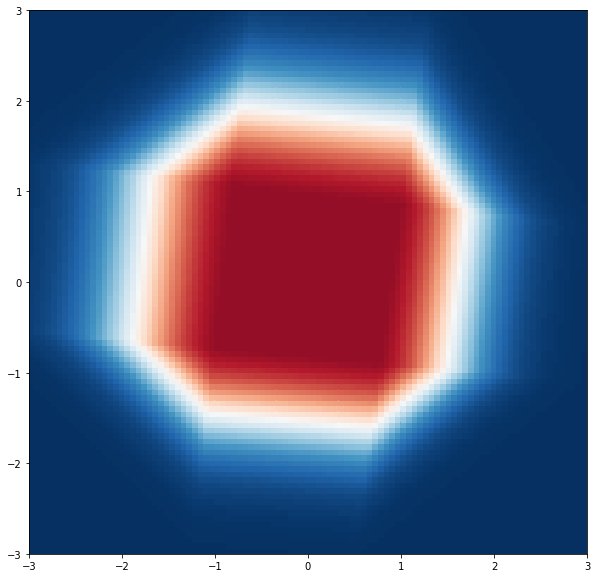

Epoch: 701 Loss: 0.3052648603916168
Epoch: 702 Loss: 0.28105124831199646
Epoch: 703 Loss: 0.3021368980407715
Epoch: 704 Loss: 0.2794928550720215
Epoch: 705 Loss: 0.30061593651771545
Epoch: 706 Loss: 0.2820894420146942
Epoch: 707 Loss: 0.30416226387023926
Epoch: 708 Loss: 0.28018948435783386
Epoch: 709 Loss: 0.3040943443775177
Epoch: 710 Loss: 0.28012046217918396


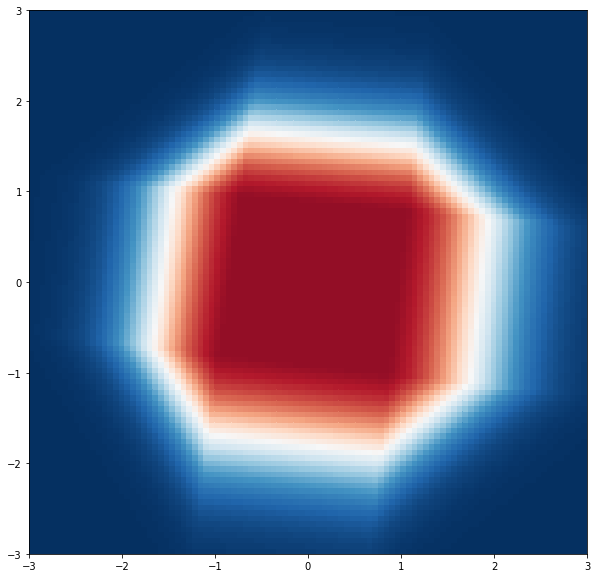

Epoch: 711 Loss: 0.3020094037055969
Epoch: 712 Loss: 0.2826493978500366
Epoch: 713 Loss: 0.3032982349395752
Epoch: 714 Loss: 0.28128209710121155
Epoch: 715 Loss: 0.3042586147785187
Epoch: 716 Loss: 0.28047430515289307
Epoch: 717 Loss: 0.3029405176639557
Epoch: 718 Loss: 0.28095999360084534
Epoch: 719 Loss: 0.30373454093933105
Epoch: 720 Loss: 0.28022322058677673


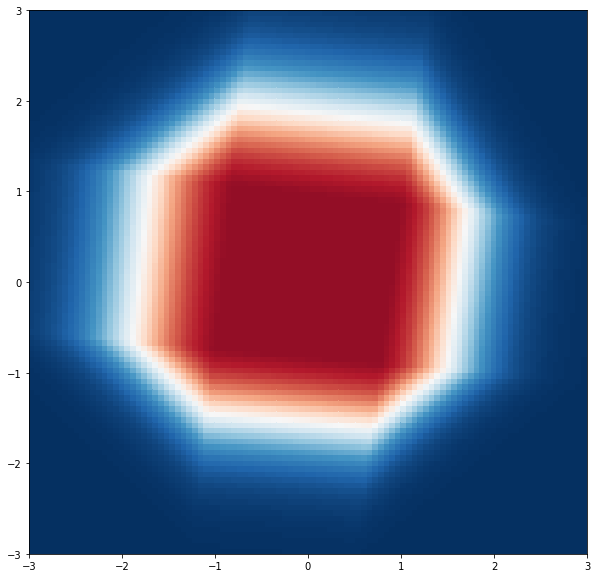

Epoch: 721 Loss: 0.3013596534729004
Epoch: 722 Loss: 0.28357747197151184
Epoch: 723 Loss: 0.304282009601593
Epoch: 724 Loss: 0.28112176060676575
Epoch: 725 Loss: 0.30063149333000183
Epoch: 726 Loss: 0.283929705619812
Epoch: 727 Loss: 0.3038257956504822
Epoch: 728 Loss: 0.2789880037307739
Epoch: 729 Loss: 0.3030550479888916
Epoch: 730 Loss: 0.2810511291027069


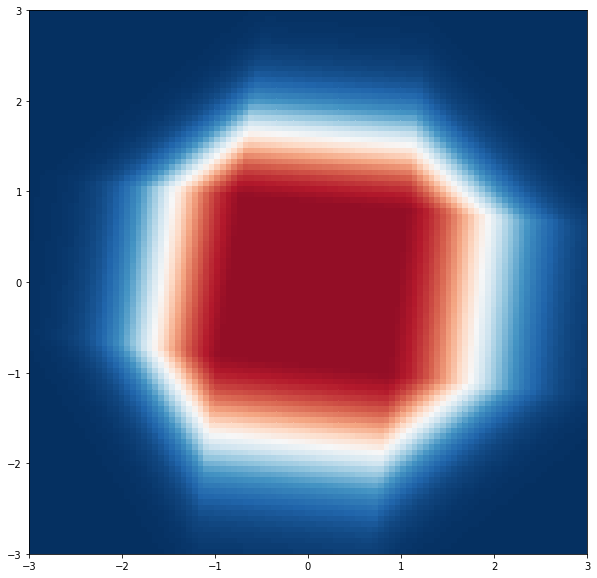

Epoch: 731 Loss: 0.3023459017276764
Epoch: 732 Loss: 0.28277596831321716
Epoch: 733 Loss: 0.3037188649177551
Epoch: 734 Loss: 0.2797805666923523
Epoch: 735 Loss: 0.30136358737945557
Epoch: 736 Loss: 0.28352901339530945
Epoch: 737 Loss: 0.302670419216156
Epoch: 738 Loss: 0.2794509530067444
Epoch: 739 Loss: 0.30221453309059143
Epoch: 740 Loss: 0.281225323677063


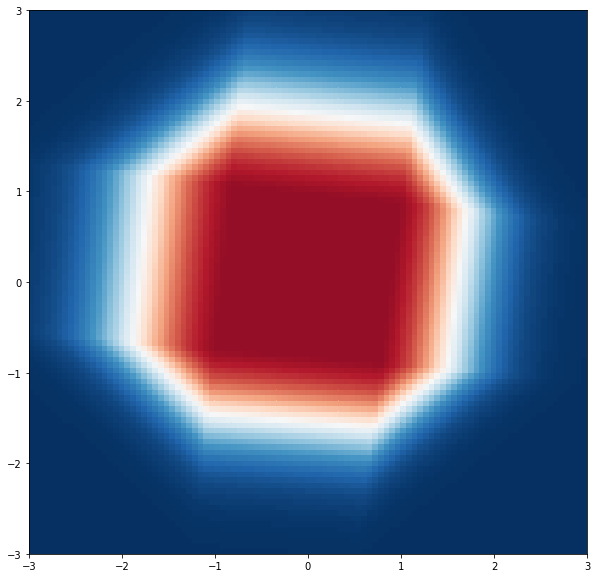

Epoch: 741 Loss: 0.3031010031700134
Epoch: 742 Loss: 0.27986326813697815
Epoch: 743 Loss: 0.3006803095340729
Epoch: 744 Loss: 0.28333765268325806
Epoch: 745 Loss: 0.3025963306427002
Epoch: 746 Loss: 0.27992963790893555
Epoch: 747 Loss: 0.30224037170410156
Epoch: 748 Loss: 0.2819339632987976
Epoch: 749 Loss: 0.3030431270599365
Epoch: 750 Loss: 0.27964478731155396


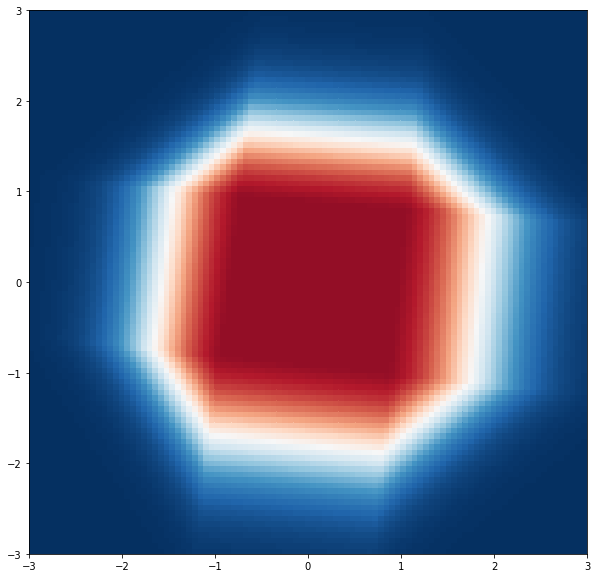

Epoch: 751 Loss: 0.30058708786964417
Epoch: 752 Loss: 0.28230735659599304
Epoch: 753 Loss: 0.3050171434879303
Epoch: 754 Loss: 0.28189510107040405
Epoch: 755 Loss: 0.3020787835121155
Epoch: 756 Loss: 0.2797488868236542
Epoch: 757 Loss: 0.3013784885406494
Epoch: 758 Loss: 0.2824710011482239
Epoch: 759 Loss: 0.3030119836330414
Epoch: 760 Loss: 0.28033438324928284


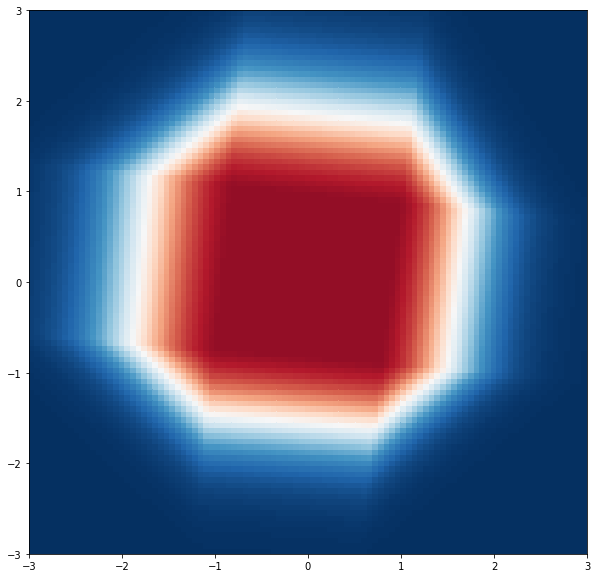

Epoch: 761 Loss: 0.30178195238113403
Epoch: 762 Loss: 0.2813972234725952
Epoch: 763 Loss: 0.30263563990592957
Epoch: 764 Loss: 0.28005778789520264
Epoch: 765 Loss: 0.3011503219604492
Epoch: 766 Loss: 0.2819002866744995
Epoch: 767 Loss: 0.30314362049102783
Epoch: 768 Loss: 0.28066548705101013
Epoch: 769 Loss: 0.30247047543525696
Epoch: 770 Loss: 0.280621737241745


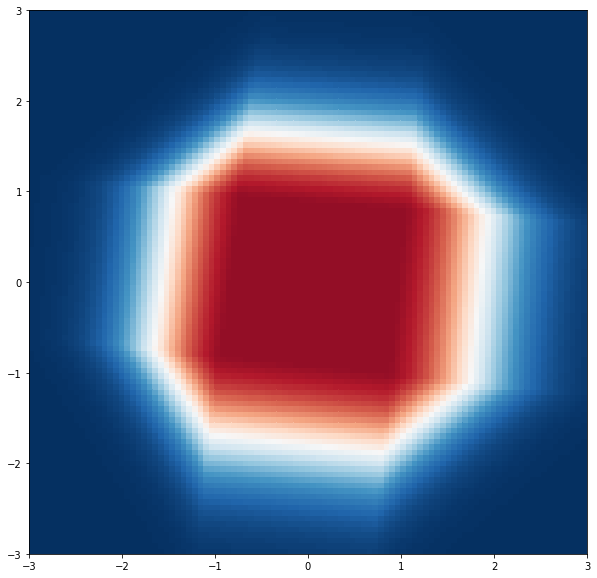

Epoch: 771 Loss: 0.30238690972328186
Epoch: 772 Loss: 0.2795473039150238
Epoch: 773 Loss: 0.3012699782848358
Epoch: 774 Loss: 0.281787633895874
Epoch: 775 Loss: 0.3032936751842499
Epoch: 776 Loss: 0.28043195605278015
Epoch: 777 Loss: 0.3031725585460663
Epoch: 778 Loss: 0.2812418043613434
Epoch: 779 Loss: 0.3020397126674652
Epoch: 780 Loss: 0.279704213142395


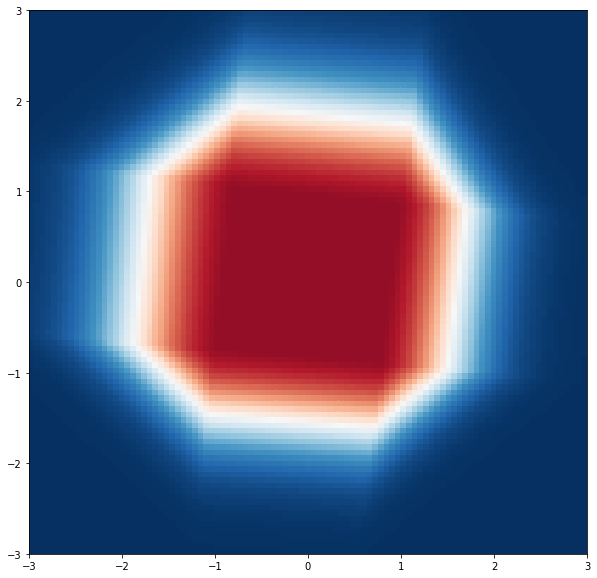

Epoch: 781 Loss: 0.30267399549484253
Epoch: 782 Loss: 0.2814803421497345
Epoch: 783 Loss: 0.3026859164237976
Epoch: 784 Loss: 0.2810933589935303
Epoch: 785 Loss: 0.3026796281337738
Epoch: 786 Loss: 0.2809160351753235
Epoch: 787 Loss: 0.30349451303482056
Epoch: 788 Loss: 0.27969807386398315
Epoch: 789 Loss: 0.3012675940990448
Epoch: 790 Loss: 0.28083691000938416


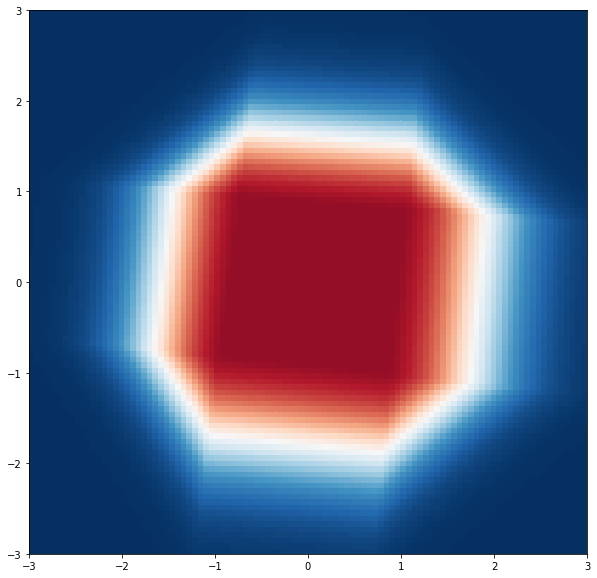

Epoch: 791 Loss: 0.3030526041984558
Epoch: 792 Loss: 0.280051589012146
Epoch: 793 Loss: 0.3028879463672638
Epoch: 794 Loss: 0.28009480237960815
Epoch: 795 Loss: 0.3034907281398773
Epoch: 796 Loss: 0.28059178590774536
Epoch: 797 Loss: 0.3020625412464142
Epoch: 798 Loss: 0.2790527045726776
Epoch: 799 Loss: 0.30280113220214844
Epoch: 800 Loss: 0.28060615062713623


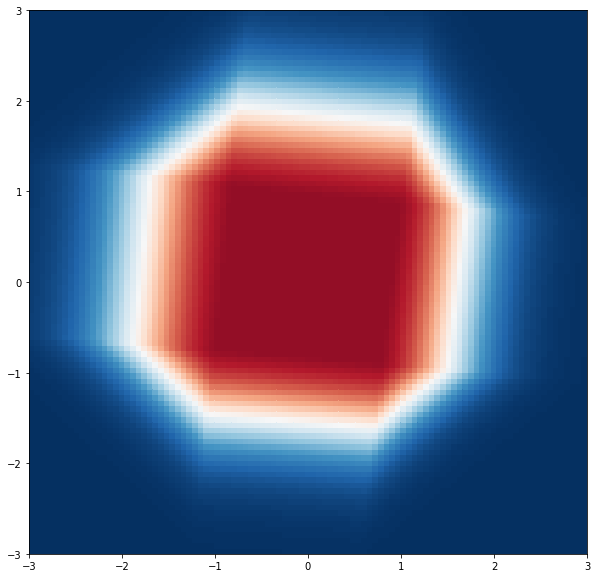

Epoch: 801 Loss: 0.30285388231277466
Epoch: 802 Loss: 0.27948275208473206
Epoch: 803 Loss: 0.3021736145019531
Epoch: 804 Loss: 0.28042781352996826
Epoch: 805 Loss: 0.3020627498626709
Epoch: 806 Loss: 0.27957841753959656
Epoch: 807 Loss: 0.3029201030731201
Epoch: 808 Loss: 0.2807929515838623
Epoch: 809 Loss: 0.30187126994132996
Epoch: 810 Loss: 0.28073859214782715


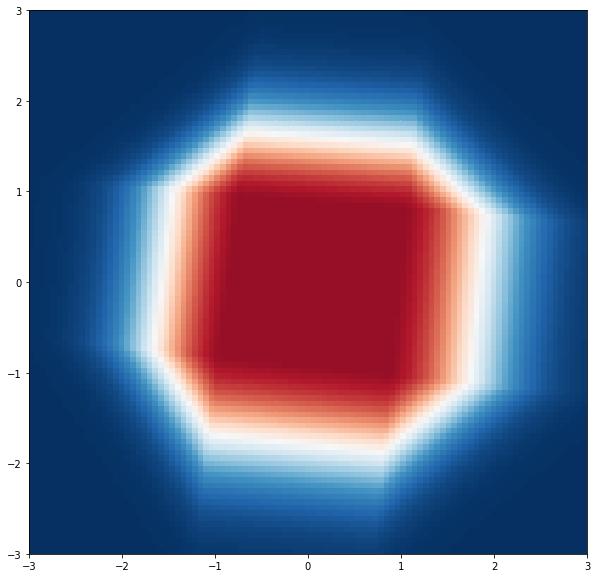

Epoch: 811 Loss: 0.3038664758205414
Epoch: 812 Loss: 0.2796165645122528
Epoch: 813 Loss: 0.30268386006355286
Epoch: 814 Loss: 0.28080880641937256
Epoch: 815 Loss: 0.3027436435222626
Epoch: 816 Loss: 0.2798593044281006
Epoch: 817 Loss: 0.30317533016204834
Epoch: 818 Loss: 0.28205740451812744
Epoch: 819 Loss: 0.3029491901397705
Epoch: 820 Loss: 0.27912724018096924


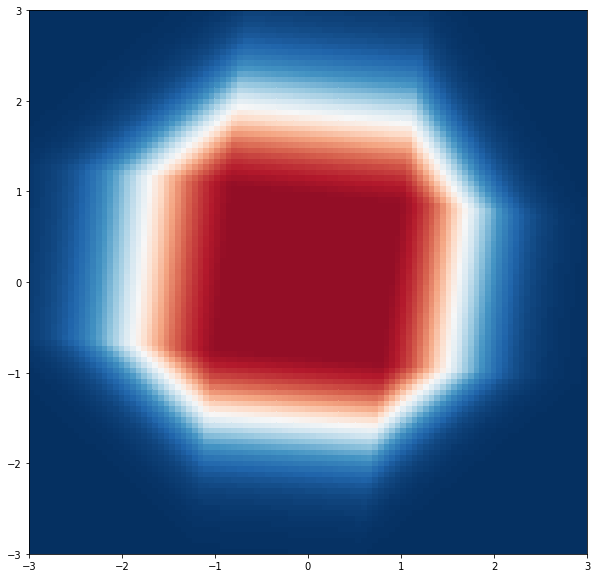

Epoch: 821 Loss: 0.30262285470962524
Epoch: 822 Loss: 0.28060078620910645
Epoch: 823 Loss: 0.30259501934051514
Epoch: 824 Loss: 0.27954623103141785
Epoch: 825 Loss: 0.3016301691532135
Epoch: 826 Loss: 0.2801273763179779
Epoch: 827 Loss: 0.30262038111686707
Epoch: 828 Loss: 0.27942129969596863
Epoch: 829 Loss: 0.3024080991744995
Epoch: 830 Loss: 0.28160902857780457


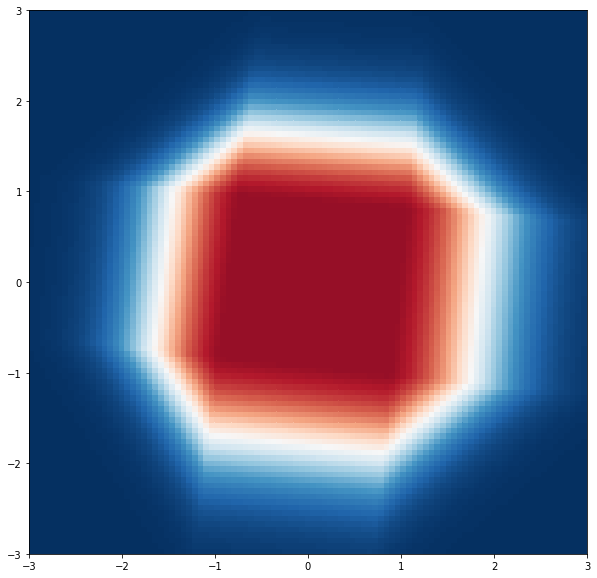

Epoch: 831 Loss: 0.30223456025123596
Epoch: 832 Loss: 0.28010058403015137
Epoch: 833 Loss: 0.30204150080680847
Epoch: 834 Loss: 0.2820304334163666
Epoch: 835 Loss: 0.3031613230705261
Epoch: 836 Loss: 0.2787674367427826
Epoch: 837 Loss: 0.30183467268943787
Epoch: 838 Loss: 0.28237539529800415
Epoch: 839 Loss: 0.3014598786830902
Epoch: 840 Loss: 0.280290424823761


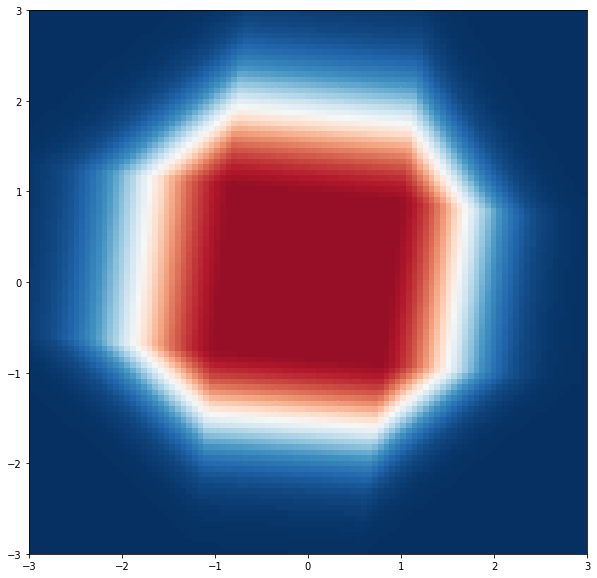

Epoch: 841 Loss: 0.3032774329185486
Epoch: 842 Loss: 0.2794530987739563
Epoch: 843 Loss: 0.30275437235832214
Epoch: 844 Loss: 0.27871739864349365
Epoch: 845 Loss: 0.3023209869861603
Epoch: 846 Loss: 0.2814154624938965
Epoch: 847 Loss: 0.3020443618297577
Epoch: 848 Loss: 0.2794097363948822
Epoch: 849 Loss: 0.30292364954948425
Epoch: 850 Loss: 0.2798292636871338


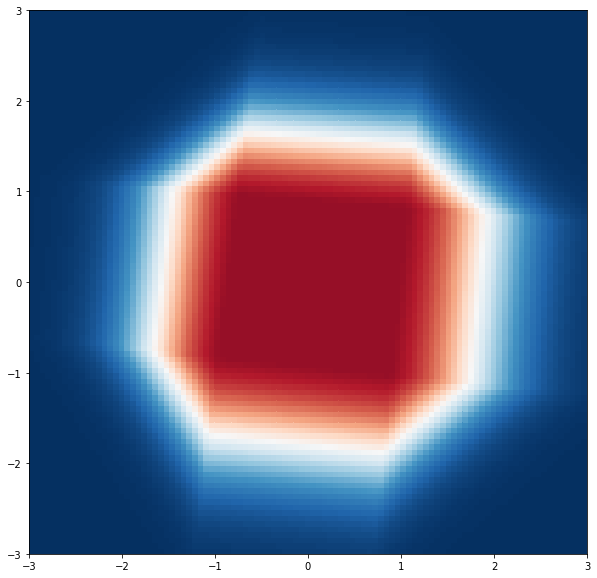

Epoch: 851 Loss: 0.30204856395721436
Epoch: 852 Loss: 0.2800580859184265
Epoch: 853 Loss: 0.3022856116294861
Epoch: 854 Loss: 0.28011372685432434
Epoch: 855 Loss: 0.3030233383178711
Epoch: 856 Loss: 0.278857946395874
Epoch: 857 Loss: 0.30273956060409546
Epoch: 858 Loss: 0.27891626954078674
Epoch: 859 Loss: 0.30203405022621155
Epoch: 860 Loss: 0.28101521730422974


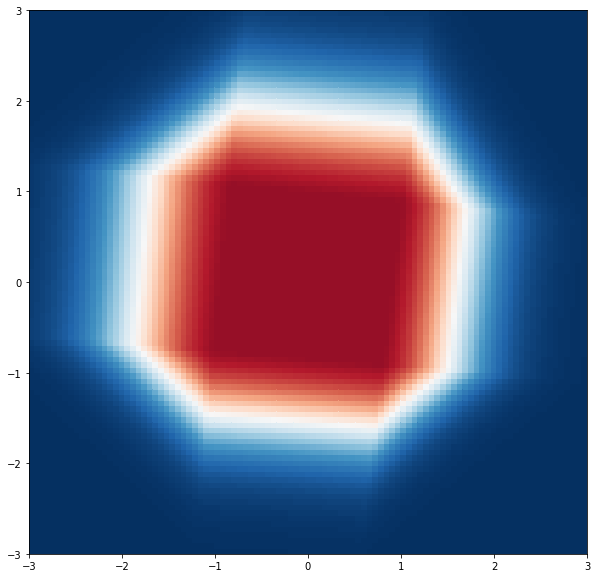

Epoch: 861 Loss: 0.30276602506637573
Epoch: 862 Loss: 0.2794557213783264
Epoch: 863 Loss: 0.3021150529384613
Epoch: 864 Loss: 0.27997735142707825
Epoch: 865 Loss: 0.30203258991241455
Epoch: 866 Loss: 0.2805500328540802
Epoch: 867 Loss: 0.30248138308525085
Epoch: 868 Loss: 0.2807264029979706
Epoch: 869 Loss: 0.30305907130241394
Epoch: 870 Loss: 0.27964091300964355


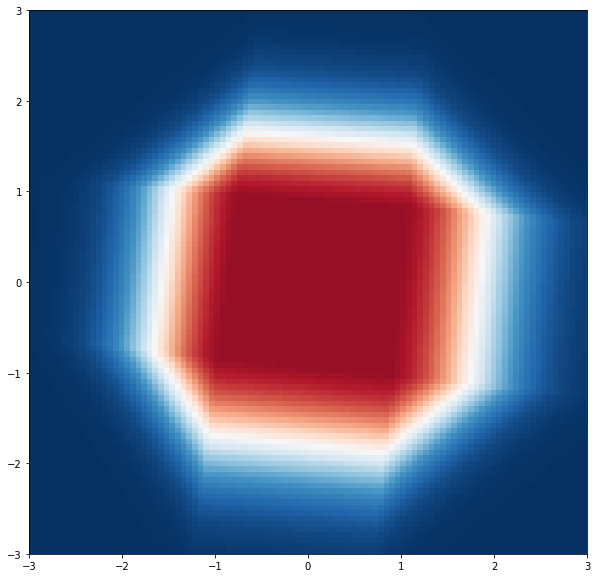

Epoch: 871 Loss: 0.3013436198234558
Epoch: 872 Loss: 0.28075194358825684
Epoch: 873 Loss: 0.3021828532218933
Epoch: 874 Loss: 0.2804025113582611
Epoch: 875 Loss: 0.30194607377052307
Epoch: 876 Loss: 0.2802180051803589
Epoch: 877 Loss: 0.3022661507129669
Epoch: 878 Loss: 0.2805626690387726
Epoch: 879 Loss: 0.3013980984687805
Epoch: 880 Loss: 0.2797202169895172


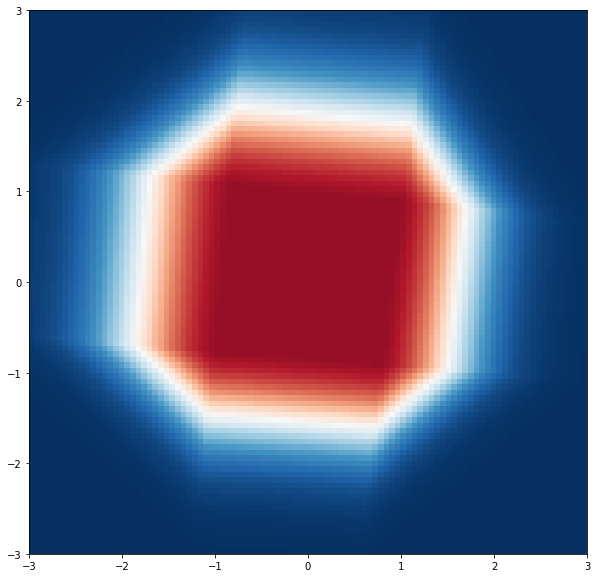

Epoch: 881 Loss: 0.3028006851673126
Epoch: 882 Loss: 0.27967360615730286
Epoch: 883 Loss: 0.3024190366268158
Epoch: 884 Loss: 0.28086715936660767
Epoch: 885 Loss: 0.30263715982437134
Epoch: 886 Loss: 0.2792615592479706
Epoch: 887 Loss: 0.3021579682826996
Epoch: 888 Loss: 0.28065213561058044
Epoch: 889 Loss: 0.30324435234069824
Epoch: 890 Loss: 0.2795355021953583


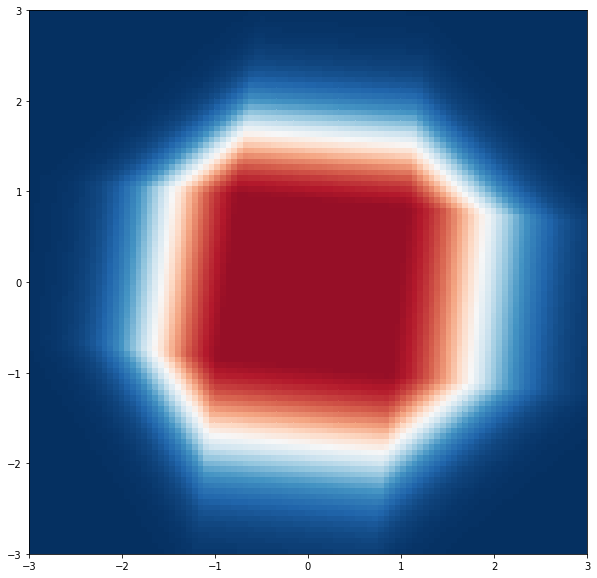

Epoch: 891 Loss: 0.30247411131858826
Epoch: 892 Loss: 0.27952784299850464
Epoch: 893 Loss: 0.3028929531574249
Epoch: 894 Loss: 0.27846986055374146
Epoch: 895 Loss: 0.30129730701446533
Epoch: 896 Loss: 0.28074103593826294
Epoch: 897 Loss: 0.30185580253601074
Epoch: 898 Loss: 0.28064289689064026
Epoch: 899 Loss: 0.30184677243232727
Epoch: 900 Loss: 0.2810981869697571


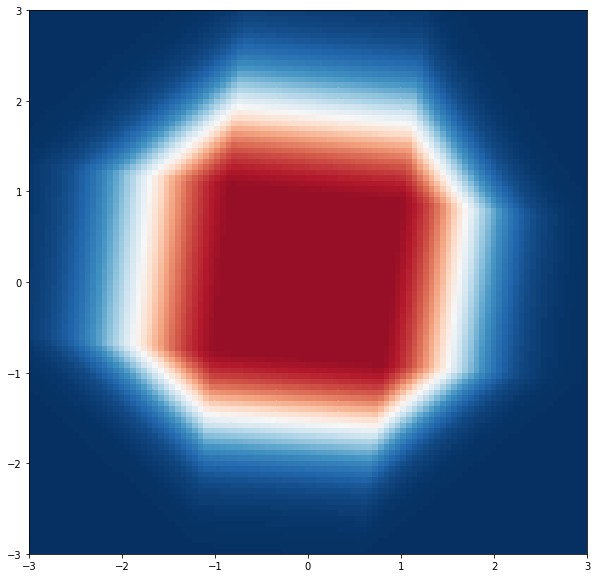

Epoch: 901 Loss: 0.3020690679550171
Epoch: 902 Loss: 0.2799987494945526
Epoch: 903 Loss: 0.3022889494895935
Epoch: 904 Loss: 0.27895501255989075
Epoch: 905 Loss: 0.3018375635147095
Epoch: 906 Loss: 0.2811279594898224
Epoch: 907 Loss: 0.30220913887023926
Epoch: 908 Loss: 0.2796991467475891
Epoch: 909 Loss: 0.3033507764339447
Epoch: 910 Loss: 0.27913105487823486


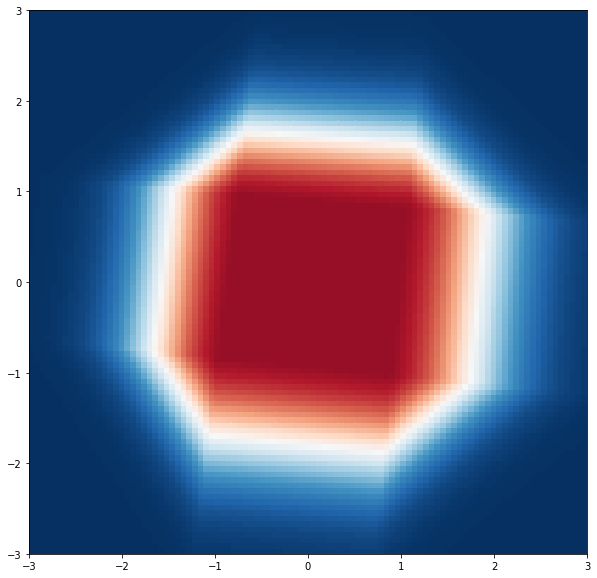

Epoch: 911 Loss: 0.30192023515701294
Epoch: 912 Loss: 0.2802862226963043
Epoch: 913 Loss: 0.30208882689476013
Epoch: 914 Loss: 0.2803039848804474
Epoch: 915 Loss: 0.3015575110912323
Epoch: 916 Loss: 0.27916592359542847
Epoch: 917 Loss: 0.30232974886894226
Epoch: 918 Loss: 0.2799310088157654
Epoch: 919 Loss: 0.3018493056297302
Epoch: 920 Loss: 0.2806055247783661


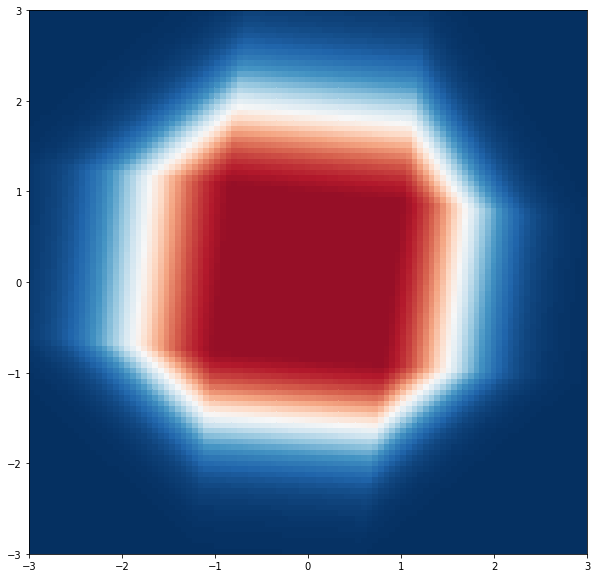

Epoch: 921 Loss: 0.3028551936149597
Epoch: 922 Loss: 0.27888280153274536
Epoch: 923 Loss: 0.3015404939651489
Epoch: 924 Loss: 0.28180044889450073
Epoch: 925 Loss: 0.30171632766723633
Epoch: 926 Loss: 0.2805948853492737
Epoch: 927 Loss: 0.3015543222427368
Epoch: 928 Loss: 0.2814773619174957
Epoch: 929 Loss: 0.3033023476600647
Epoch: 930 Loss: 0.2782454788684845


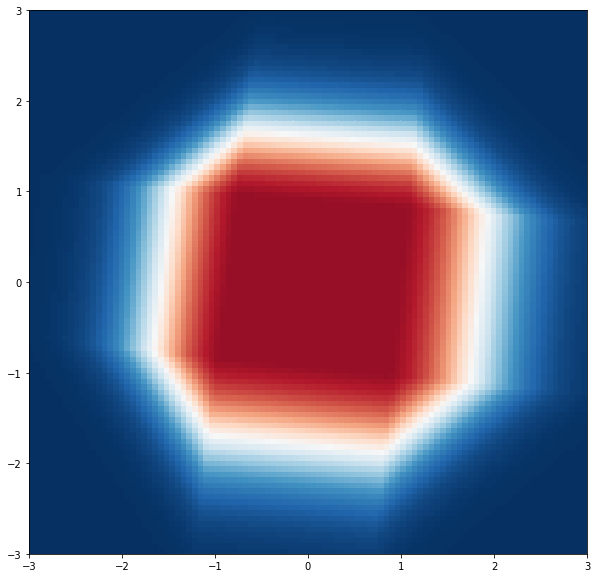

Epoch: 931 Loss: 0.3010762333869934
Epoch: 932 Loss: 0.2814997434616089
Epoch: 933 Loss: 0.3025839626789093
Epoch: 934 Loss: 0.27926400303840637
Epoch: 935 Loss: 0.3007238805294037
Epoch: 936 Loss: 0.281137615442276
Epoch: 937 Loss: 0.30318447947502136
Epoch: 938 Loss: 0.2781573235988617
Epoch: 939 Loss: 0.30033475160598755
Epoch: 940 Loss: 0.2805689871311188


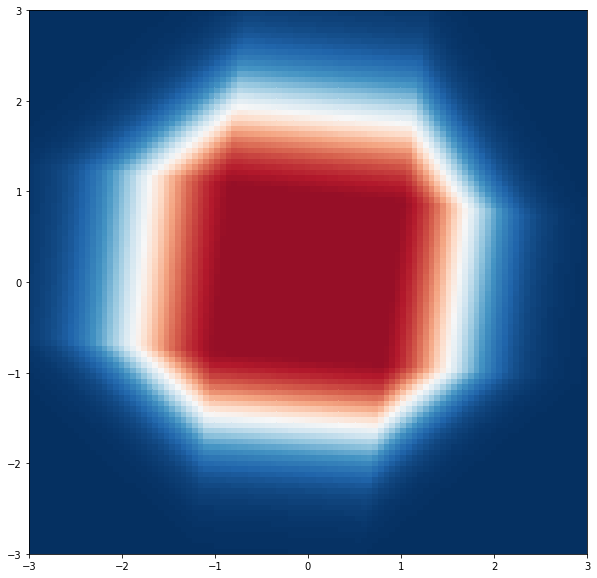

Epoch: 941 Loss: 0.3018369972705841
Epoch: 942 Loss: 0.28005915880203247
Epoch: 943 Loss: 0.3012297749519348
Epoch: 944 Loss: 0.28045201301574707
Epoch: 945 Loss: 0.3024025857448578
Epoch: 946 Loss: 0.278968870639801
Epoch: 947 Loss: 0.302280068397522
Epoch: 948 Loss: 0.2813836336135864
Epoch: 949 Loss: 0.302867591381073
Epoch: 950 Loss: 0.2792300879955292


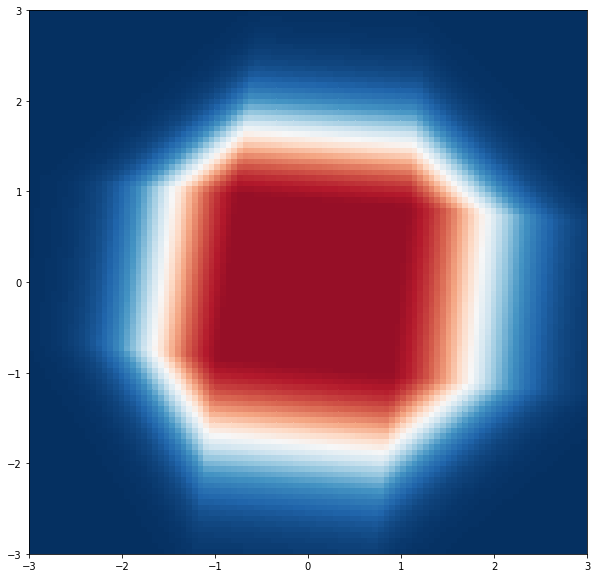

Epoch: 951 Loss: 0.30199846625328064
Epoch: 952 Loss: 0.2797187566757202
Epoch: 953 Loss: 0.30176103115081787
Epoch: 954 Loss: 0.27988114953041077
Epoch: 955 Loss: 0.30219796299934387
Epoch: 956 Loss: 0.27908486127853394
Epoch: 957 Loss: 0.301730751991272
Epoch: 958 Loss: 0.28058314323425293
Epoch: 959 Loss: 0.301733136177063
Epoch: 960 Loss: 0.2794434130191803


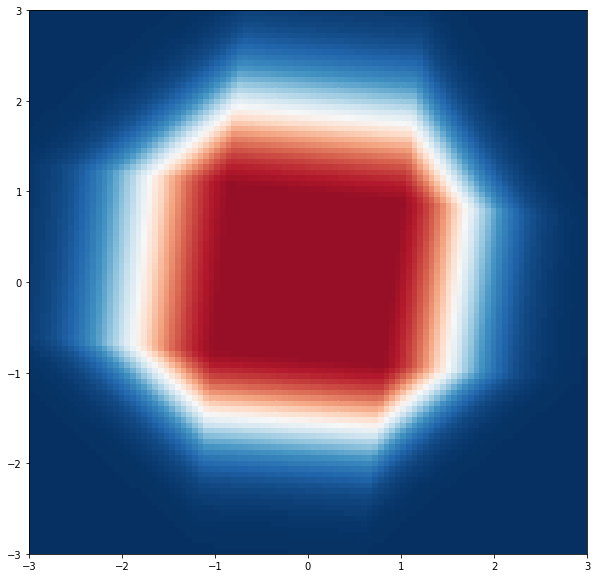

Epoch: 961 Loss: 0.301492840051651
Epoch: 962 Loss: 0.2796823978424072
Epoch: 963 Loss: 0.3026135563850403
Epoch: 964 Loss: 0.2793179750442505
Epoch: 965 Loss: 0.3024722635746002
Epoch: 966 Loss: 0.28019097447395325
Epoch: 967 Loss: 0.30065977573394775
Epoch: 968 Loss: 0.27921637892723083
Epoch: 969 Loss: 0.30280518531799316
Epoch: 970 Loss: 0.28059059381484985


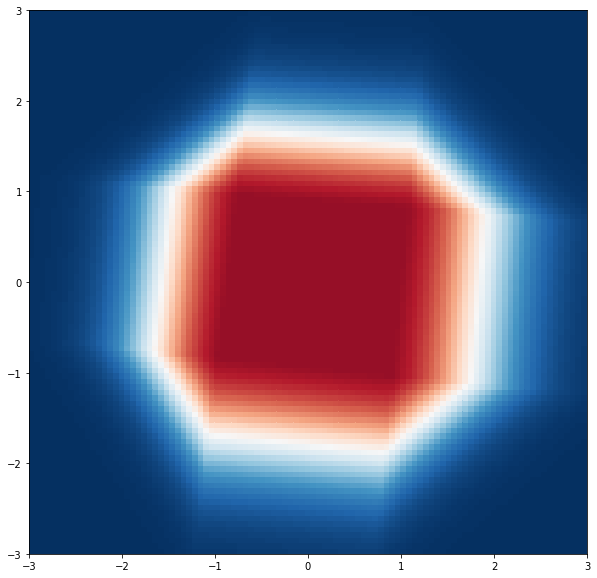

Epoch: 971 Loss: 0.30155205726623535
Epoch: 972 Loss: 0.27899348735809326
Epoch: 973 Loss: 0.3025912642478943
Epoch: 974 Loss: 0.27873024344444275
Epoch: 975 Loss: 0.30029457807540894
Epoch: 976 Loss: 0.2779640853404999
Epoch: 977 Loss: 0.30083703994750977
Epoch: 978 Loss: 0.2795807719230652
Epoch: 979 Loss: 0.30341729521751404
Epoch: 980 Loss: 0.27955392003059387


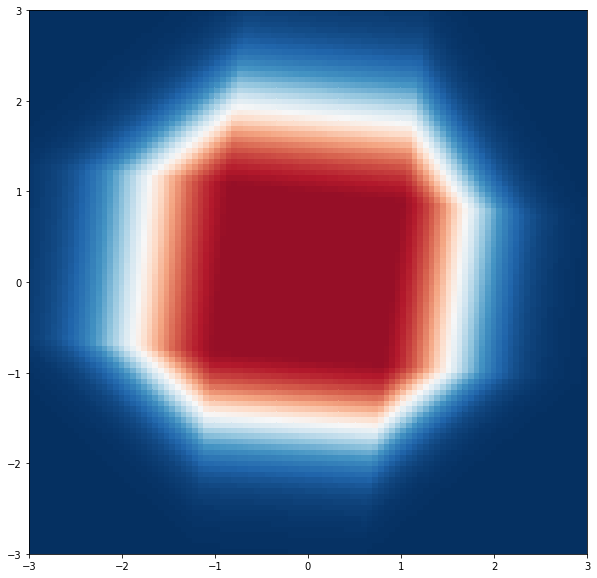

Epoch: 981 Loss: 0.3017767667770386
Epoch: 982 Loss: 0.2807573974132538
Epoch: 983 Loss: 0.3035602569580078
Epoch: 984 Loss: 0.27937081456184387
Epoch: 985 Loss: 0.2996126413345337
Epoch: 986 Loss: 0.27871328592300415
Epoch: 987 Loss: 0.3024666905403137
Epoch: 988 Loss: 0.27746906876564026
Epoch: 989 Loss: 0.3018060028553009
Epoch: 990 Loss: 0.2810019552707672


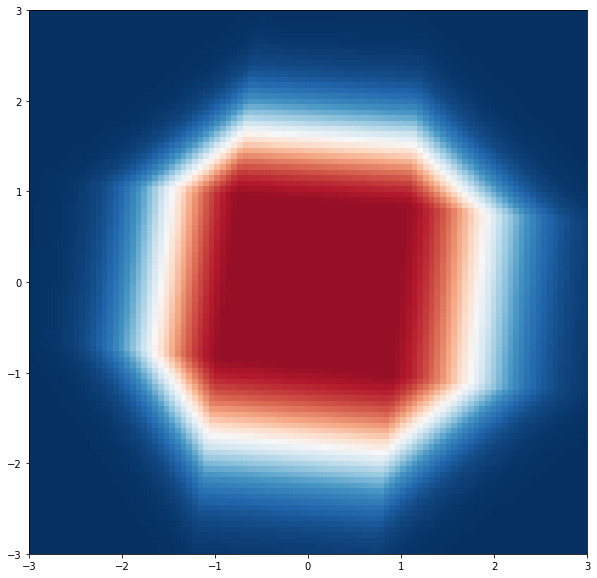

Epoch: 991 Loss: 0.30070334672927856
Epoch: 992 Loss: 0.2790297865867615
Epoch: 993 Loss: 0.30362892150878906
Epoch: 994 Loss: 0.280523419380188
Epoch: 995 Loss: 0.3015134334564209
Epoch: 996 Loss: 0.2787744700908661
Epoch: 997 Loss: 0.302751362323761
Epoch: 998 Loss: 0.28087902069091797
Epoch: 999 Loss: 0.30081355571746826


In [116]:
net = Net()
epochs = 1000
delta = 10
opt = optim.SGD(net.parameters(), lr=1)
for epoch in range(epochs):
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        # print("a", a.shape, a)
        # print("sdfs_b", sdfs_b.shape, sdfs_b)
        # print("pred", pred.shape, pred)
        # print(pred.shape)
        pred = pred.squeeze()
        # print(pred.shape)
        # print(sdfs_b.shape)
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    print("Epoch:", epoch, "Loss:", total_loss.item())
    
     if (epoch % 100 == 0):
        plot_sdf(net.forward)
    #    plot_sdf(circle.sdf)
        plt.show()
   
    

In [67]:
print(sdf_train)

[2.24264069 2.13528617 2.03094539 ... 2.03094539 2.13528617 2.24264069]


In [68]:
print(sdf_train)

[2.24264069 2.13528617 2.03094539 ... 2.03094539 2.13528617 2.24264069]


## Как закодировать несколько поверхностей одной нейросетью?

## И что?
### Кодируем известные (на момент обучения) поверхности
### Кодируем неизвестные поверхности
### Shape Completion
### Интерполяция